In [1]:
# the key idea is that instead of doing L2 training we do sobolev training ! 

# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.17.2
#   kernelspec:
#     display_name: .venv
#     language: python
#     name: python3
# ---

In [2]:
from sciml.model.deeponet import DeepONet
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sciml.data.preprocessing.process_given_dataset import get_mu_xs_sol

tf.config.list_physical_devices('GPU')

2025-08-05 21:26:32.414485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 21:26:32.424850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754443592.437836   93006 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754443592.441884   93006 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754443592.453618   93006 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
d_p = 20
d_V = 20
epochs = 10

In [4]:
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Reshape((100, 1)),  # we reshape to (batch, 100, 1)
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),  # we aggregate to (batch, 32)
    tf.keras.layers.Dense(d_V, activation='elu')  # we output d_V features
])

external_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Reshape((1, 1)),  # we reshape to (batch, 1, 1) for Conv1D
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='elu'),  # we use kernel_size=1
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='elu'),  # we use kernel_size=1
    tf.keras.layers.Flatten(),  # we flatten back to (batch, 32)
    tf.keras.layers.Dense(d_V, activation='elu')  # we output d_V features
])


I0000 00:00:1754443595.188803   93006 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


trying to enforce the boundary condition

In [5]:
class ConstrainedExternalModel(tf.keras.Model):
    def __init__(self, base_model, d_V):
        super().__init__()
        self.base_model = base_model
        self.d_V = d_V
    
    def call(self, x):
        """
        External model with boundary constraints: forces solution to be 0 at x=0 and x=1
        Uses basis functions that vanish at boundaries: x*(1-x), x^2*(1-x), etc.
        """
        # we get the base model output for learnable coefficients
        base_output = self.base_model(x)  # shape: (batch*n_points, d_V-1)
        
        # we extract x coordinates 
        x_coords = tf.squeeze(x, axis=-1)  # shape: (batch*n_points,)
        
        # we create basis functions that vanish at boundaries
        # First basis: x*(1-x) - vanishes at both x=0 and x=1
        basis_boundary = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        
        # we multiply all learned bases by x*(1-x) to ensure they vanish at boundaries
        x_factor = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        constrained_bases = base_output * x_factor
        
        # we concatenate: [x*(1-x), constrained_bases...]
        constrained_output = tf.concat([basis_boundary, constrained_bases], axis=1)
        
        return constrained_output

# we create the normal internal model (no constraints needed)
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu')
    # full d_V output
])

# we create the constrained external model
base_external = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.Dense(d_V-1, activation='elu')  # we reduce by 1 for the boundary basis
])

external_model = ConstrainedExternalModel(base_external, d_V)

In [6]:

coeff = tf.constant([-0.01,0.2,0],dtype=tf.float32)
model = DeepONet(regular_params={"internal_model": internal_model, "external_model": external_model}, hyper_params={"pinn_order":2,"pinn_coeff": coeff,"d_p": d_p, "d_V": d_V,"device": "GPU","n_epochs":epochs,"learning_rate":0.002},folder_path="/home/janis/SCIML/summerschool/data/benchmarks/given/")

2025-08-05 21:26:35,949 - sciml.model.deeponet.deeponet - INFO - Model initialized with 10 epochs, 32 batch size, 0.002 learning rate


In [7]:


# now we need to do sobolev training with custom function knowing the PDE

In [8]:
folder_path = "/home/janis/SCIML/summerschool/data/benchmarks/given/"
coeff = tf.constant([-0.01,0.2,0],dtype=tf.float32)

In [9]:
model = DeepONet(regular_params={"internal_model": internal_model, "external_model": external_model}, hyper_params={"pinn_order":2,"pinn_coeff": coeff,"d_p": d_p, "d_V": d_V,"device": "GPU","n_epochs":epochs},folder_path="/home/janis/SCIML/summerschool/data/benchmarks/given/")

2025-08-05 21:26:35,978 - sciml.model.deeponet.deeponet - INFO - Model initialized with 10 epochs, 32 batch size, 0.001 learning rate


In [10]:
mus, xs, sol = get_mu_xs_sol(folder_path,0.2)

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


In [11]:
print(mus.shape)
print(xs.shape)
print(sol.shape)

(2000, 100)
(2000, 100, 1)
(2000, 100)


mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-05 21:26:36.313781: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 21:26:36,643 - tensorflow - WARNING - Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
2025-08-05 21:26:39.770395: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-05 21:26:40,321 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:26:40,322 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.045339
2025-08-05 21:26:40,323 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.039143
Training progress:  10%|█         | 1/10 [00:03<00:35,  3.97s/it]2025-08-05 21:26:42.455145: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is abor

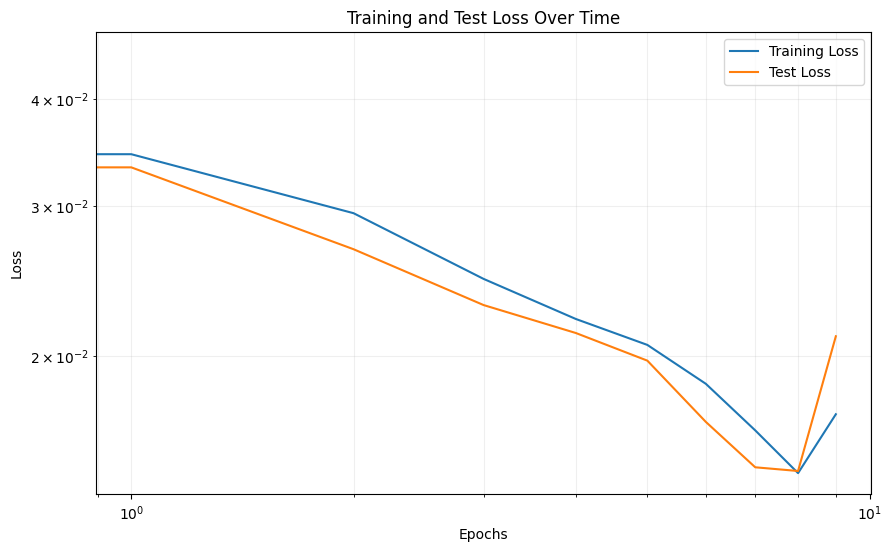

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


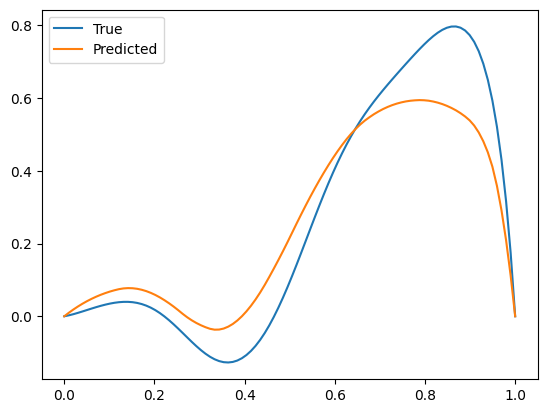

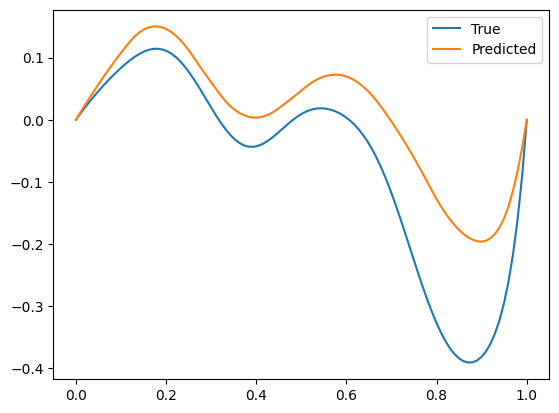

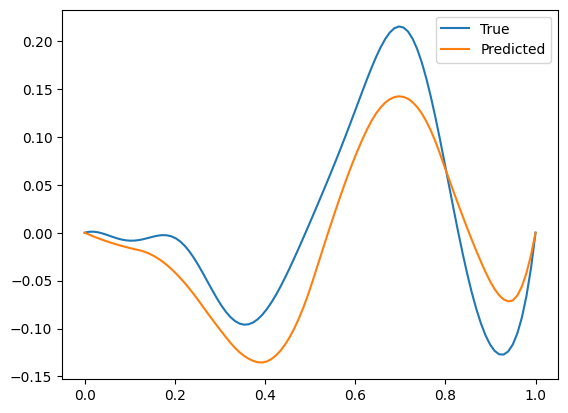

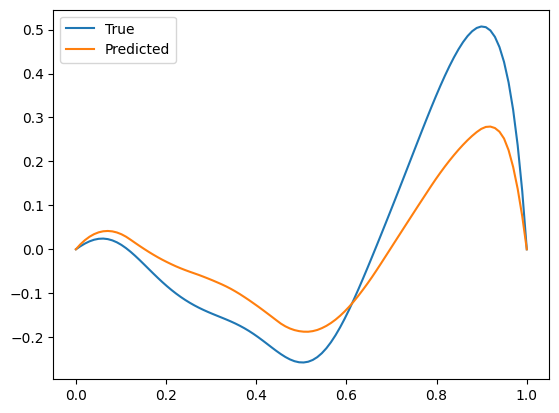

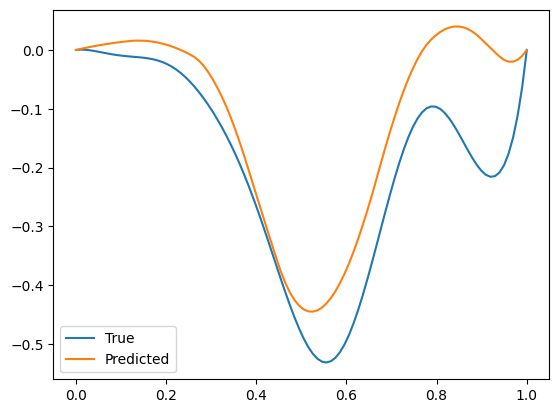

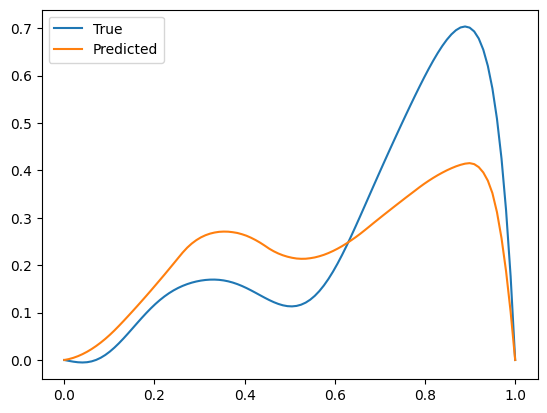

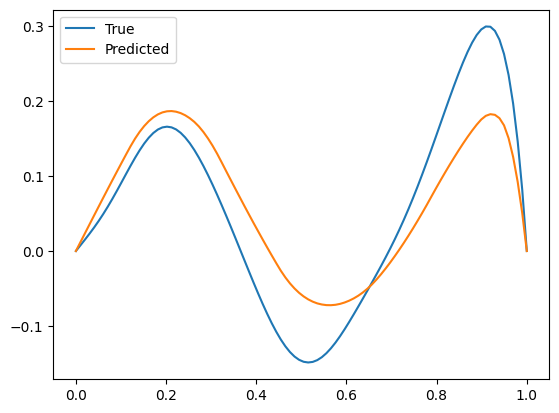

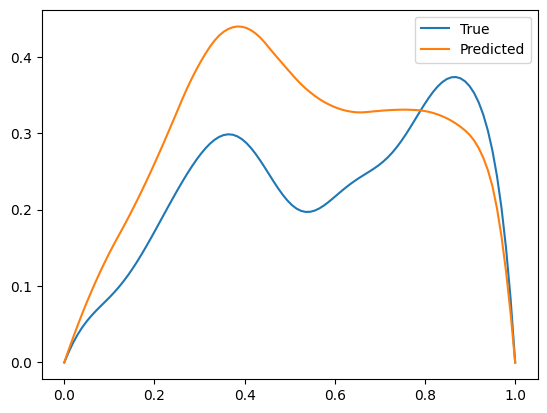

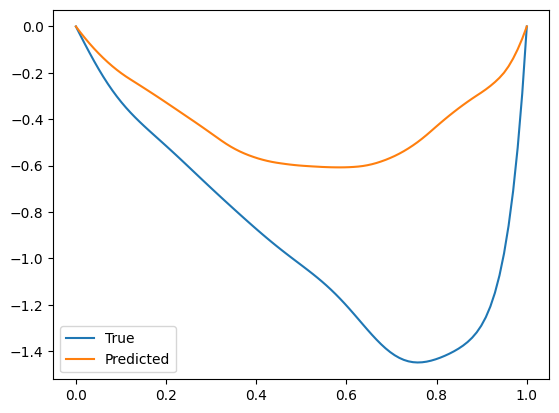

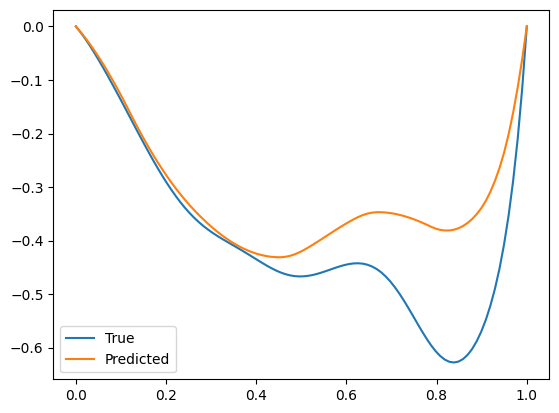

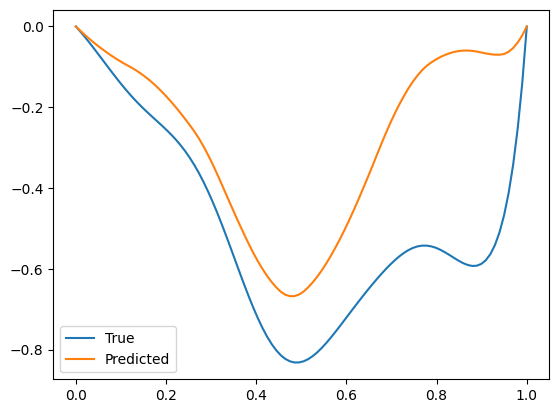

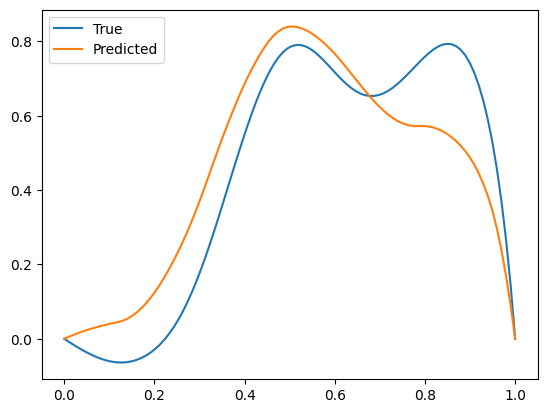

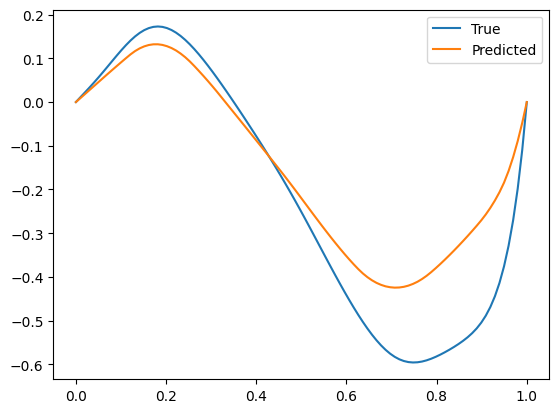

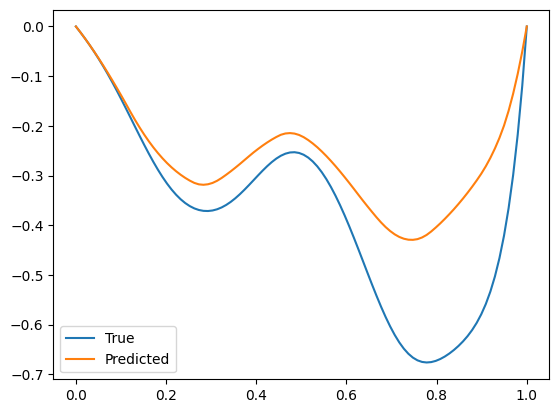

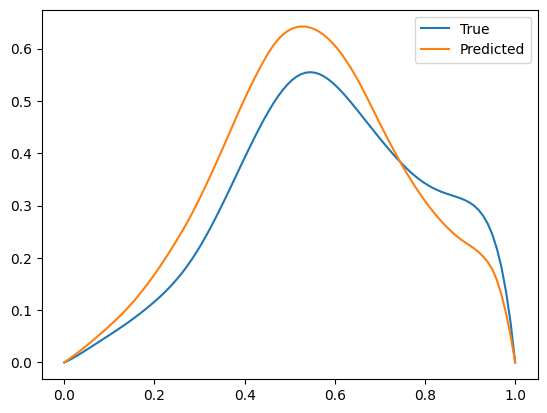

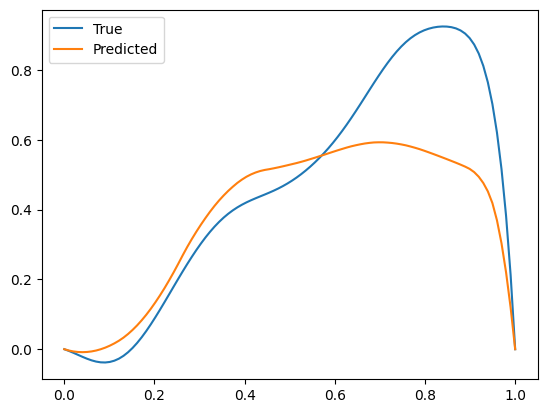

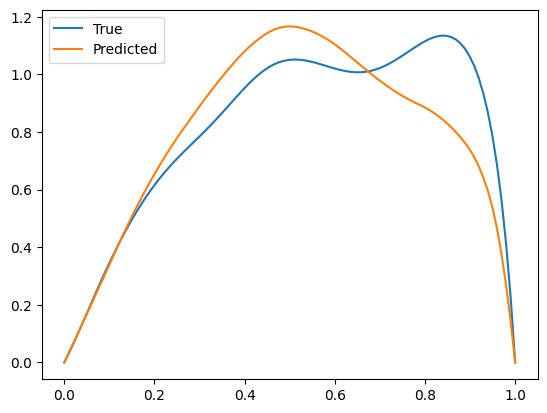

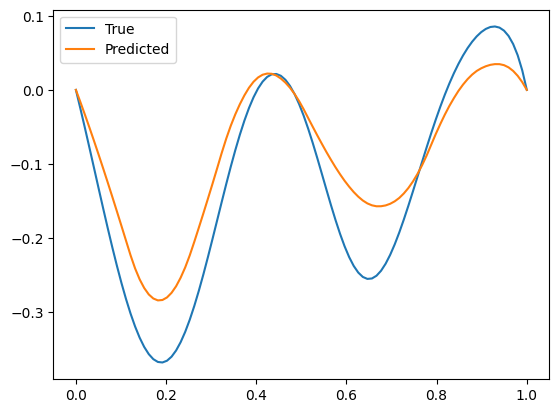

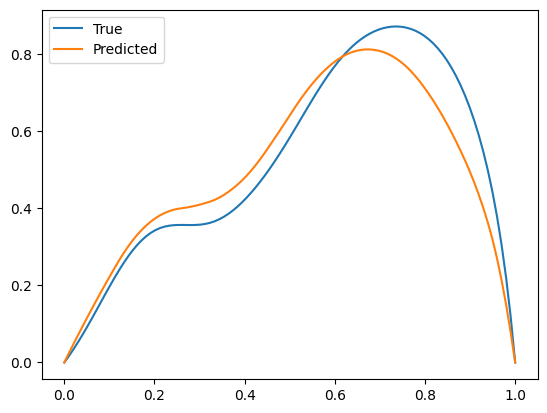

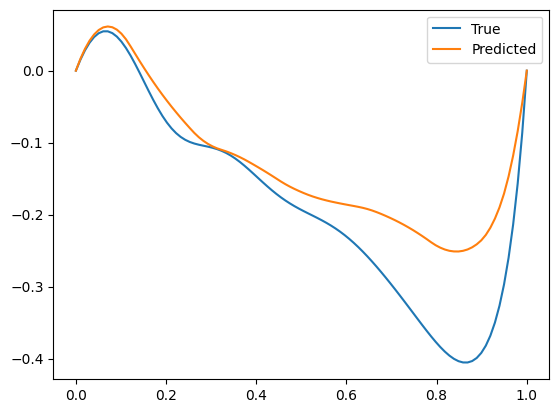

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:27:08,696 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:27:08,697 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.020709
2025-08-05 21:27:08,697 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.016756
Training progress:  10%|█         | 1/10 [00:03<00:27,  3.04s/it]2025-08-05 21:27:11,244 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:27:11,245 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.014821
2025-08-05 21:27:11,246 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.012787
Training progress:  20%|██        | 2/10 [00:05<00:22,  2.75s/it]2025-08-05 21:27:13,771 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:27:13,772 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011353
2025-08-05 21:27:13,773 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.009702
Training progress:  30%|███       | 3/10 [00:08<00:18,  2.65s/i

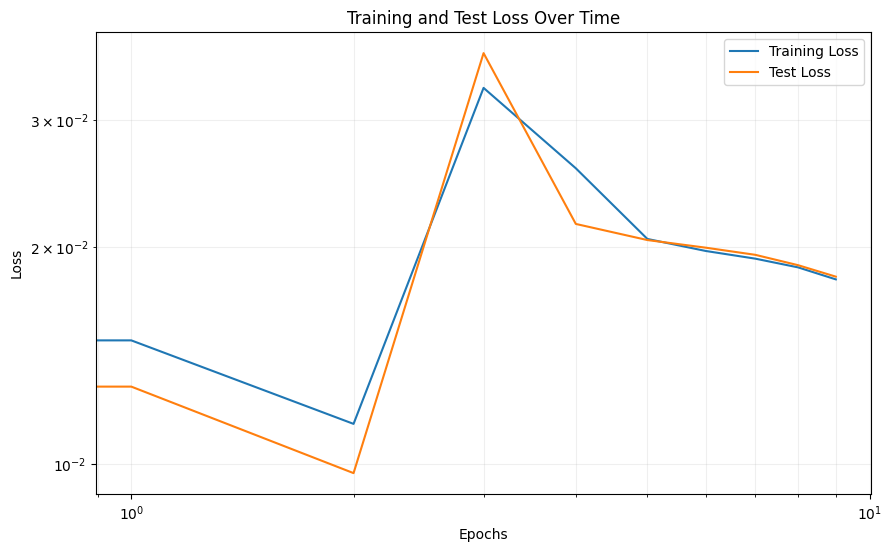

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


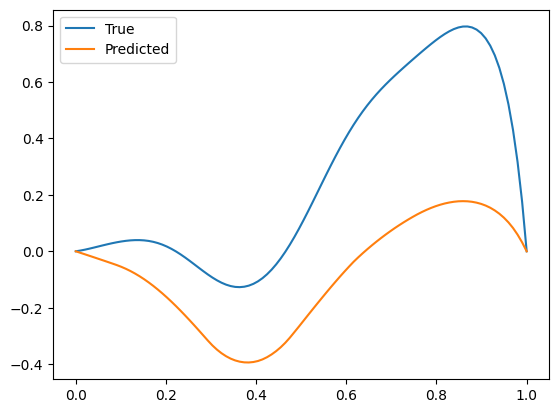

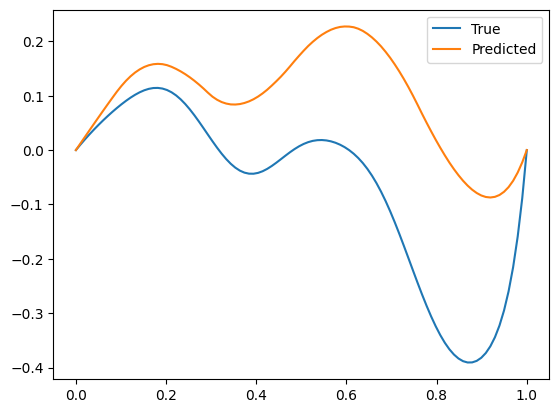

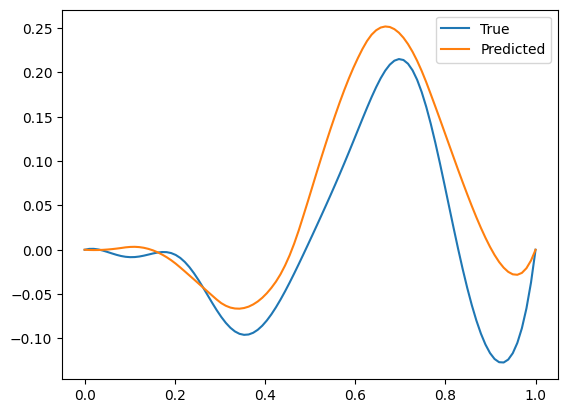

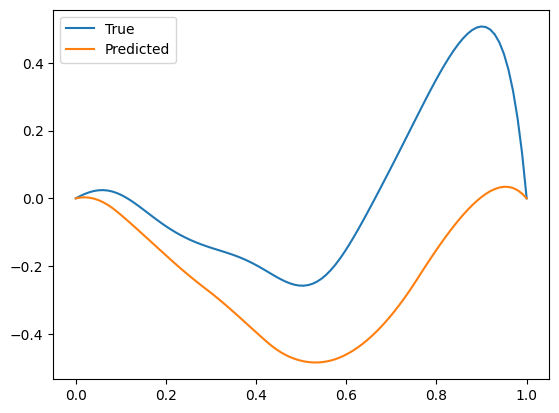

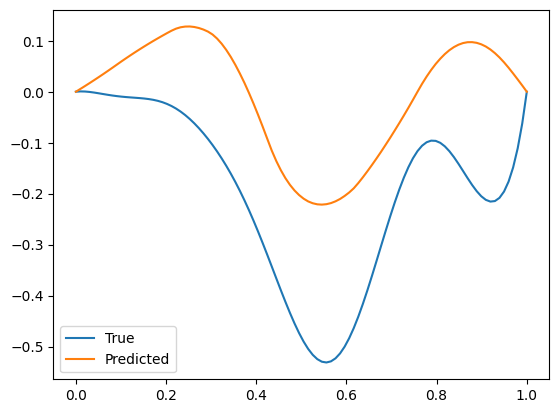

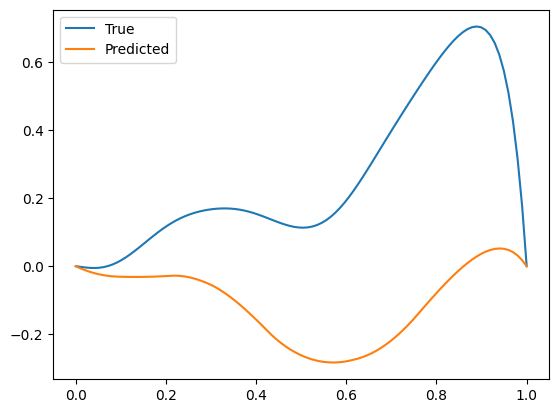

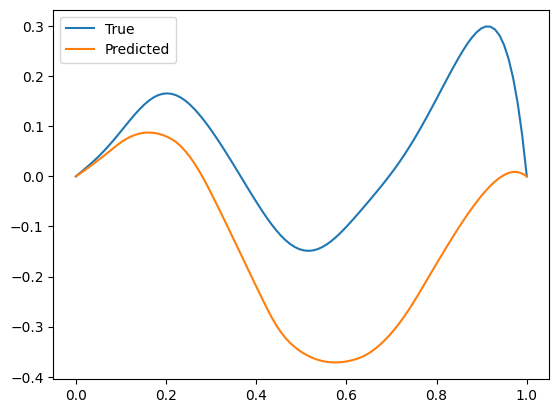

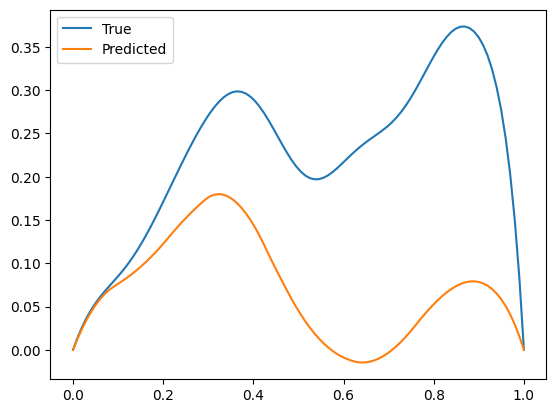

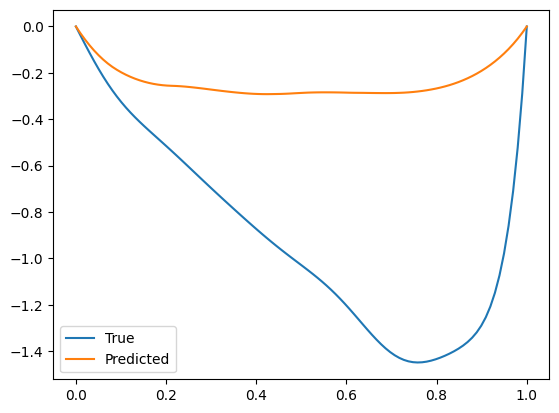

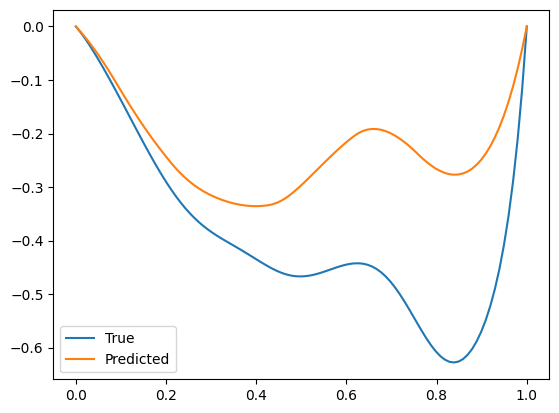

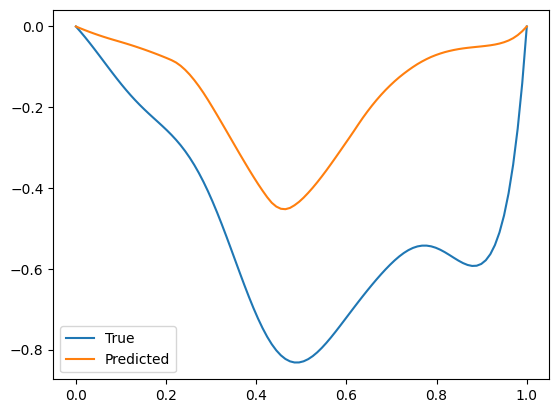

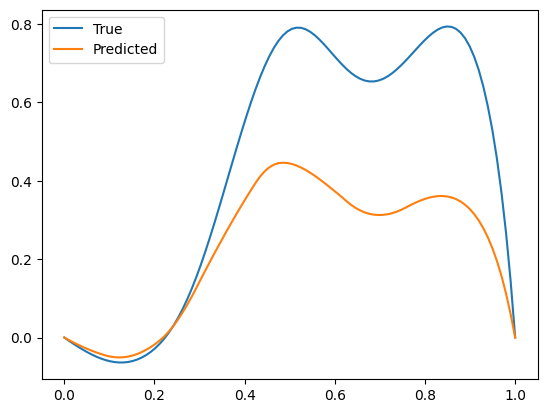

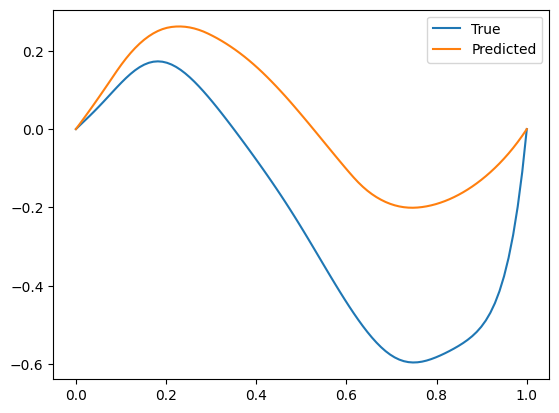

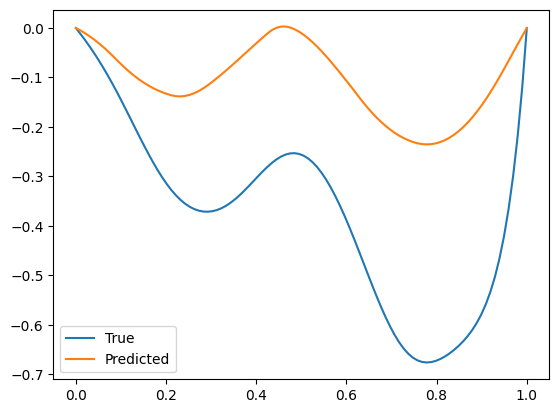

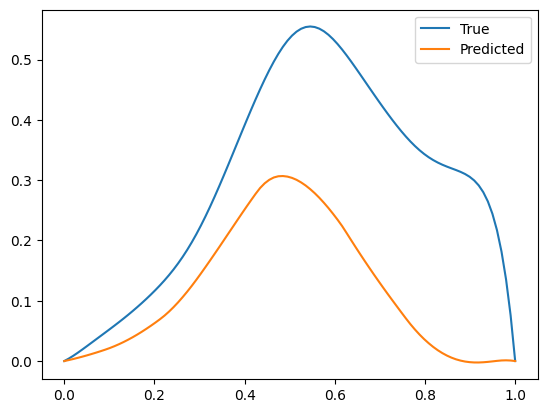

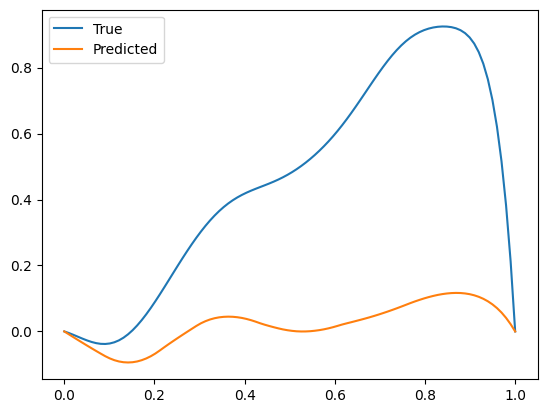

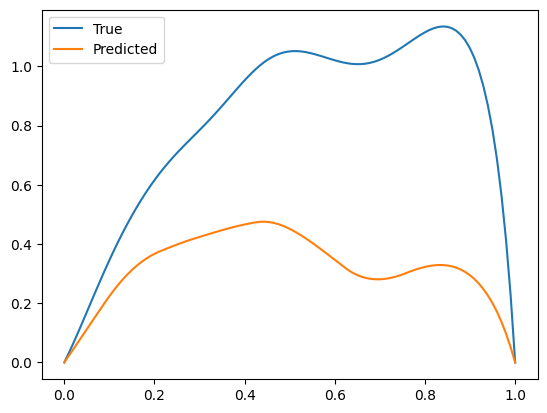

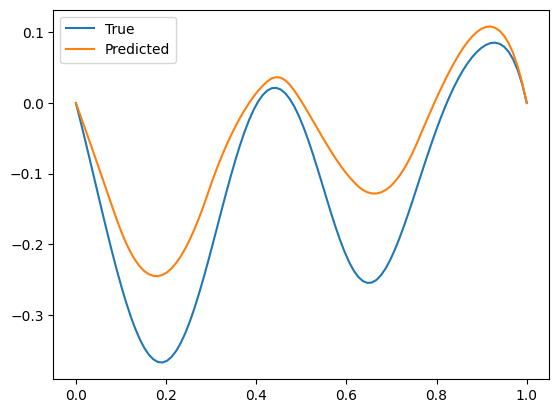

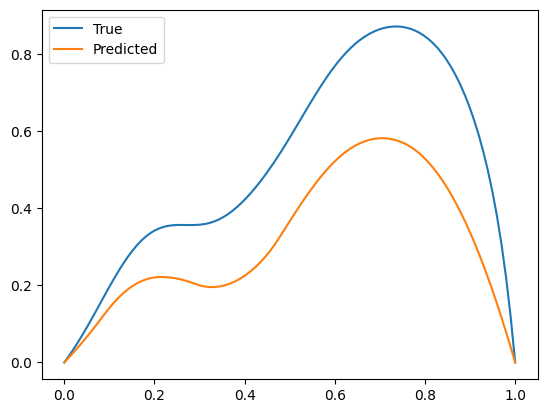

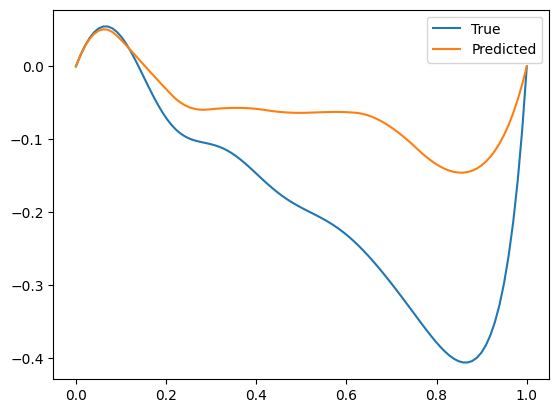

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:27:38,729 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:27:38,730 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.017087
2025-08-05 21:27:38,731 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.016864
Training progress:  10%|█         | 1/10 [00:02<00:25,  2.86s/it]2025-08-05 21:27:41,206 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:27:41,207 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.016256
2025-08-05 21:27:41,208 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.017429
Training progress:  20%|██        | 2/10 [00:05<00:21,  2.63s/it]2025-08-05 21:27:43,840 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:27:43,841 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.016002
2025-08-05 21:27:43,841 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.015483
Training progress:  30%|███       | 3/10 [00:07<00:18,  2.63s/i

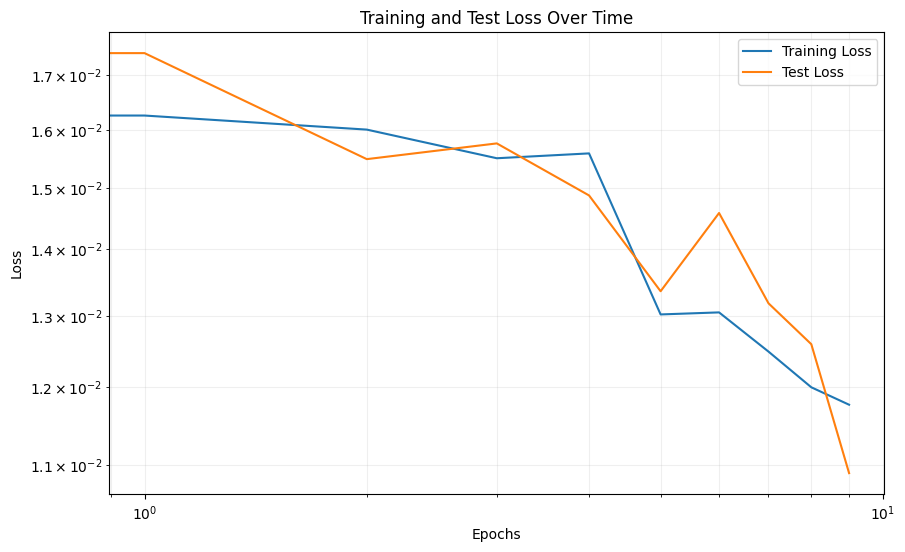

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


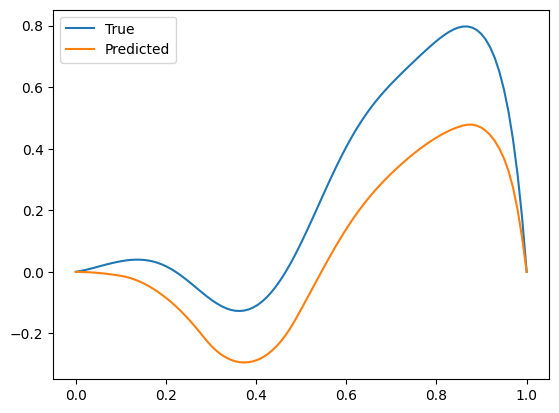

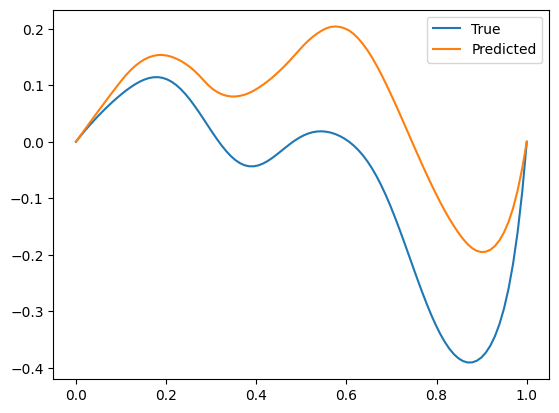

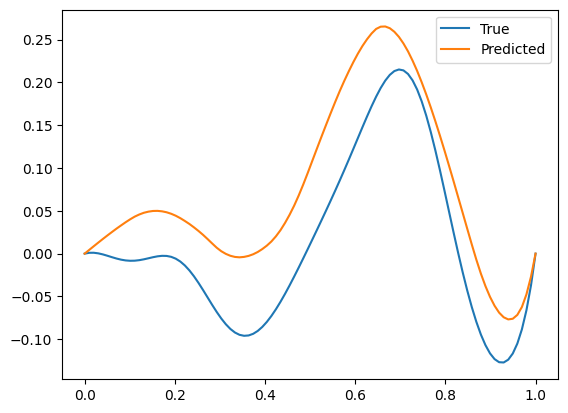

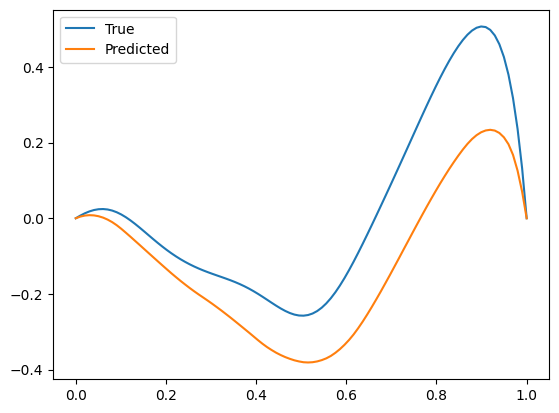

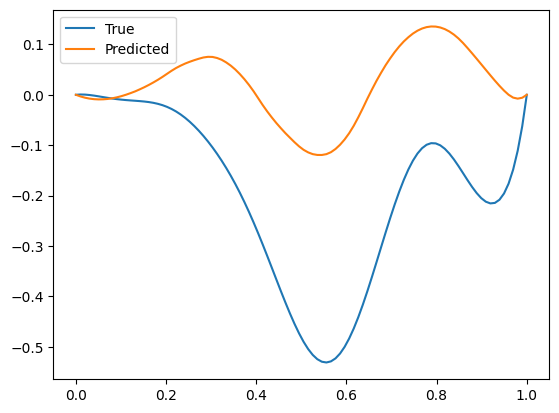

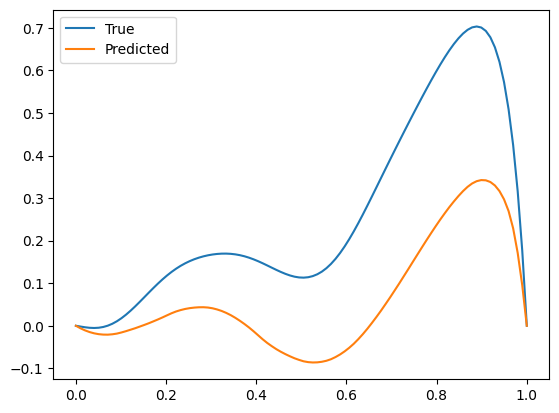

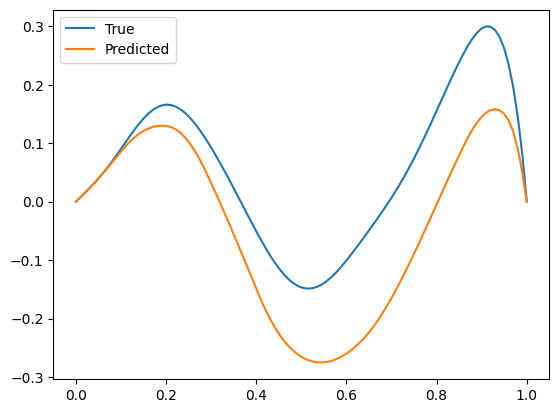

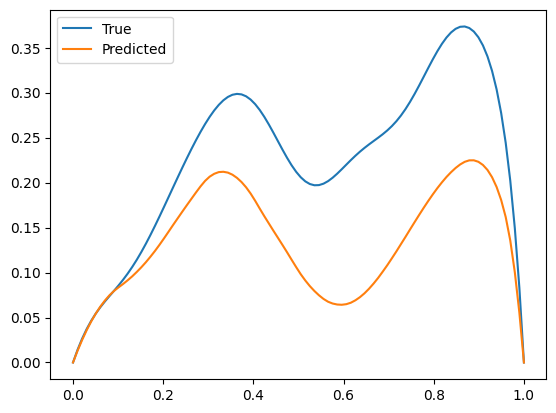

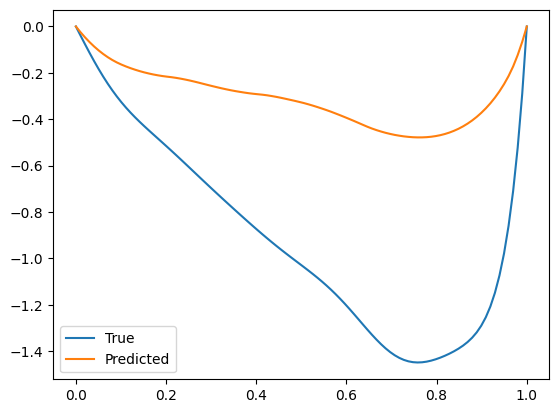

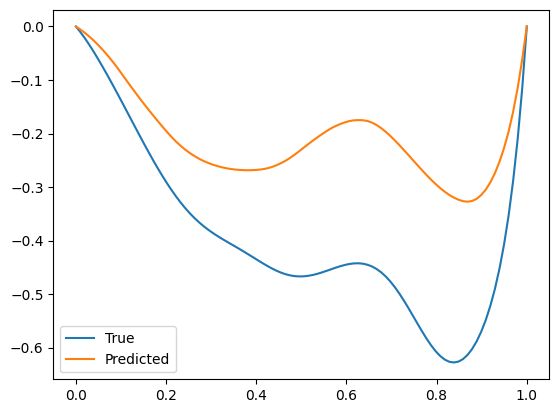

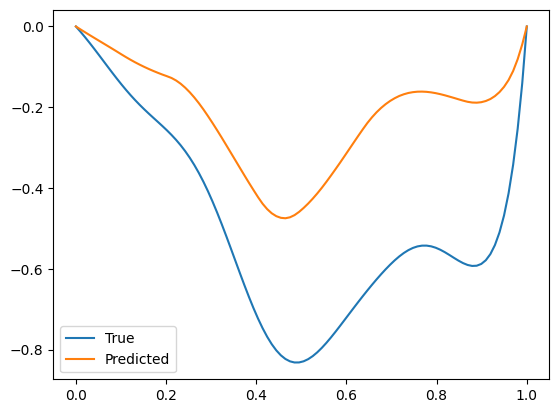

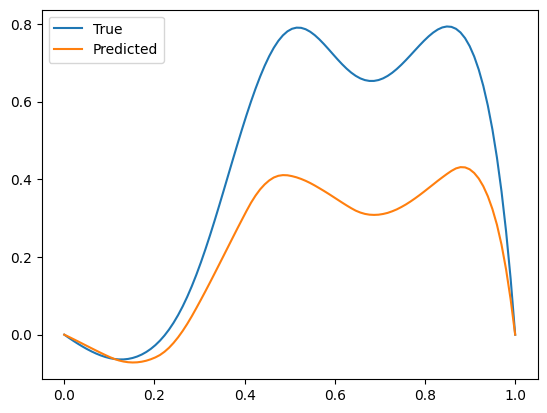

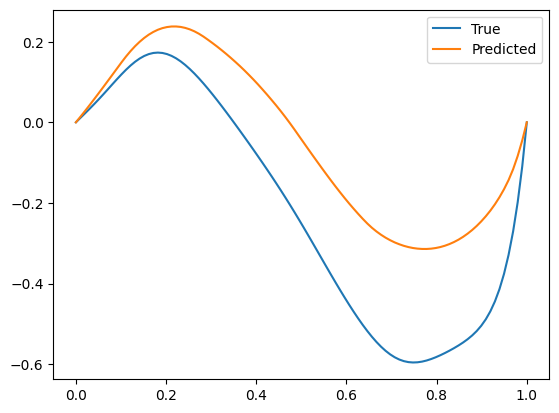

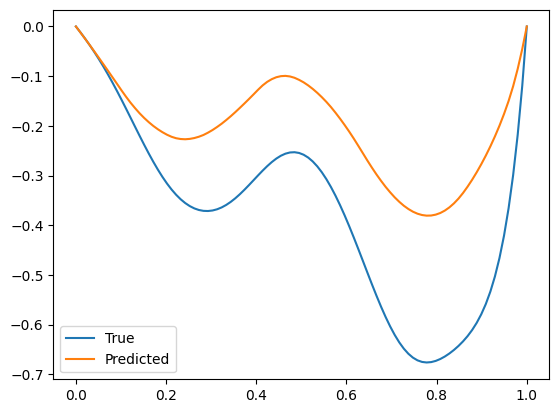

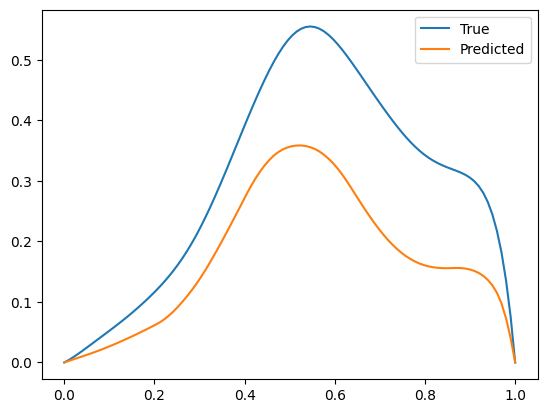

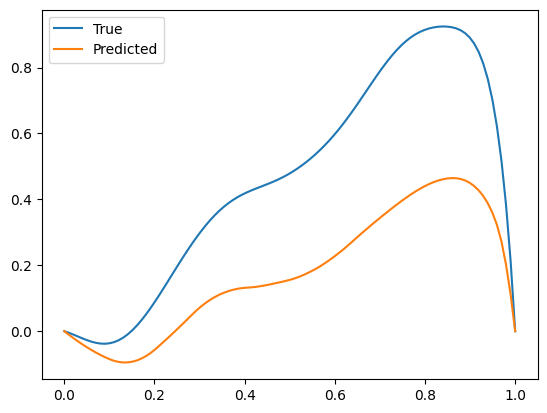

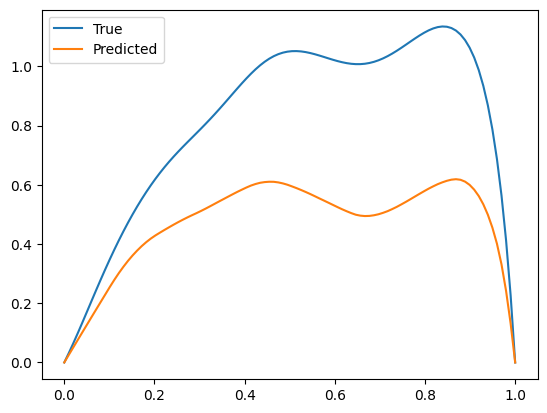

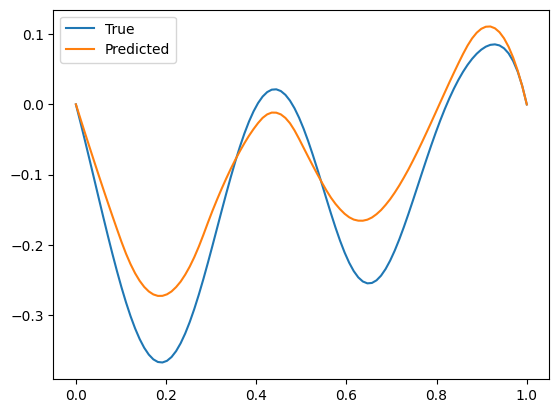

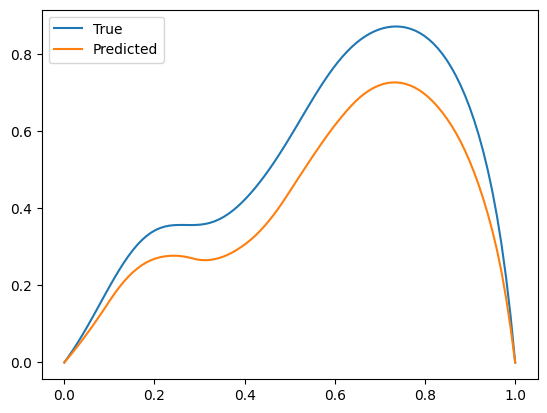

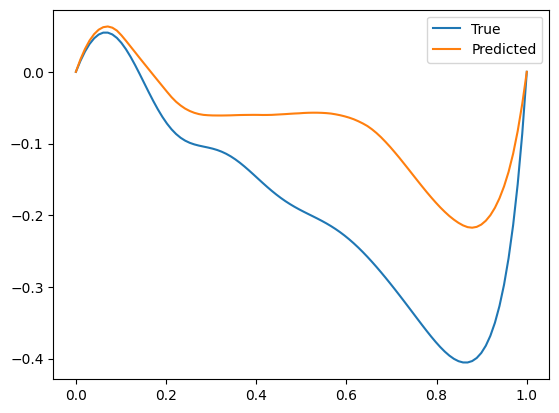

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-05 21:28:05.847569: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:28:08,873 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:28:08,874 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011129
2025-08-05 21:28:08,875 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.012413
Training progress:  10%|█         | 1/10 [00:02<00:26,  3.00s/it]2025-08-05 21:28:11,293 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:28:11,294 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011716
2025-08-05 21:28:11,294 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.010483
Training progress:  20%|██        | 2/10 [00:05<00:21,  2.66s/it]2025-08-05 21:28:13,865 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:28:13,865 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.01

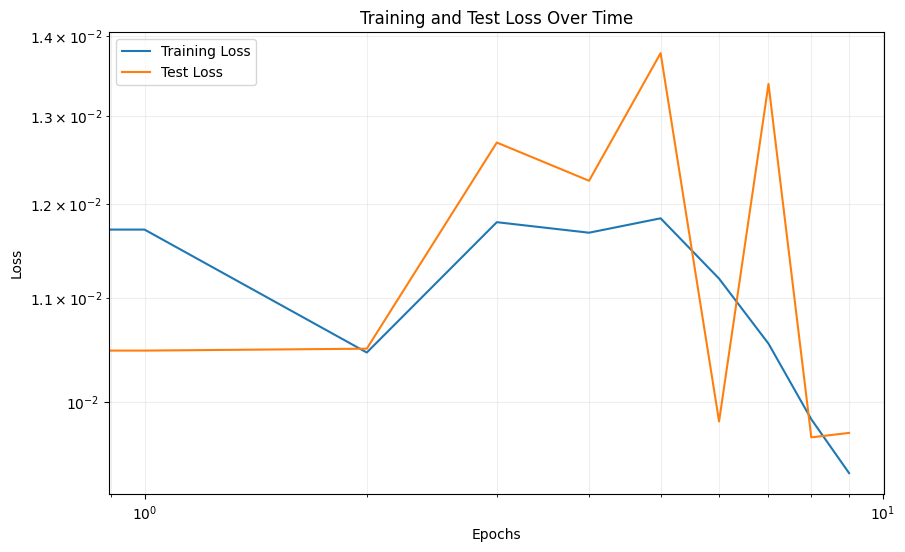

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


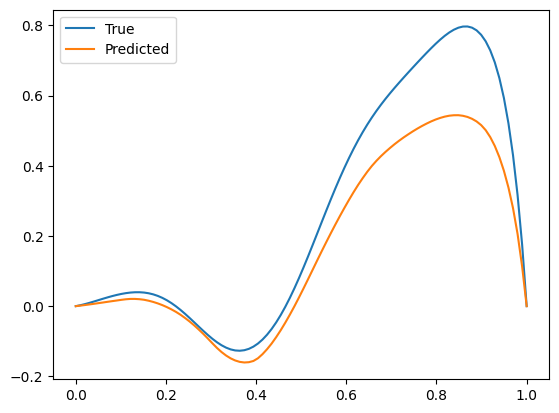

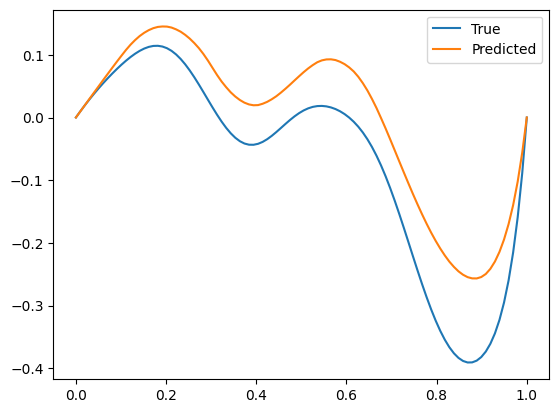

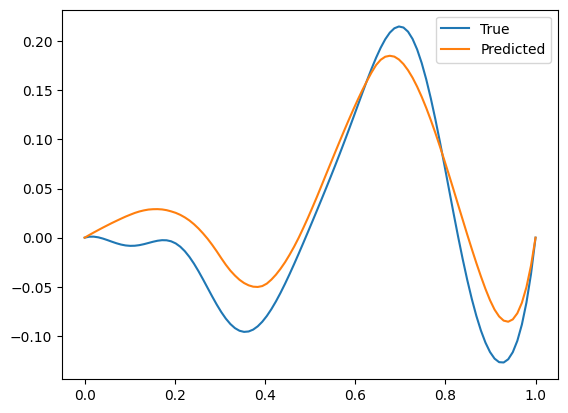

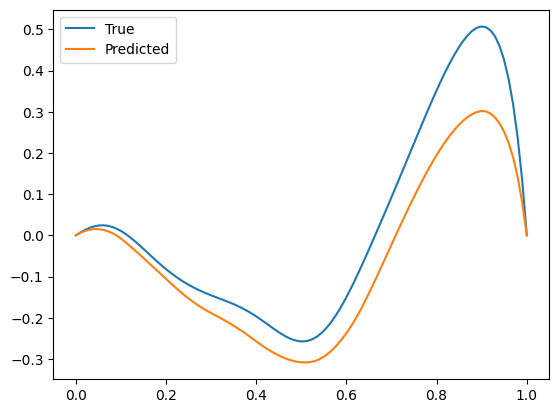

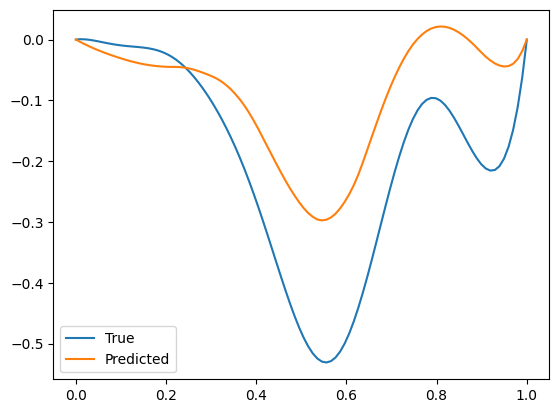

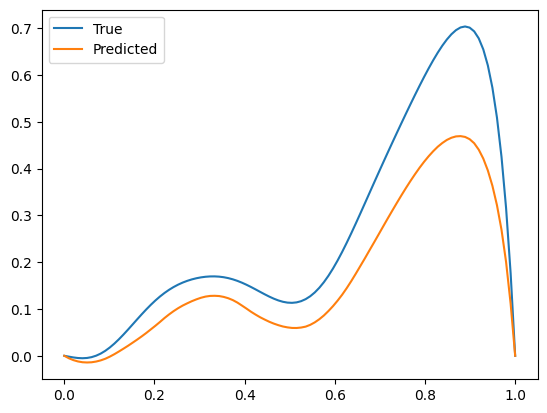

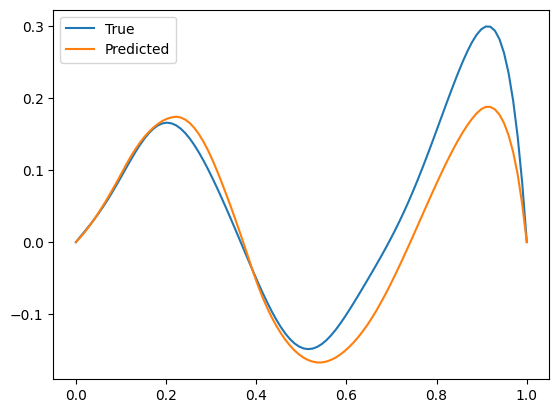

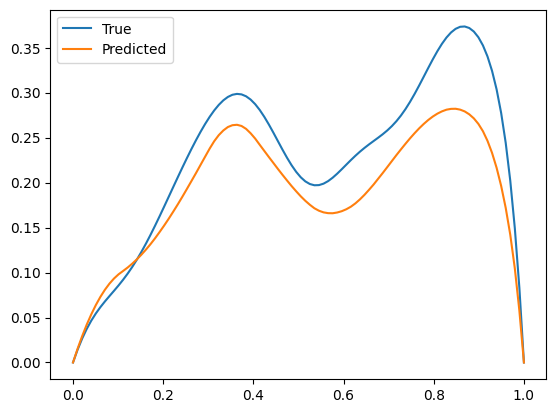

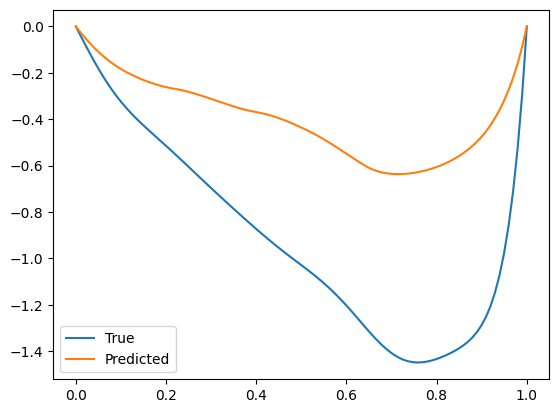

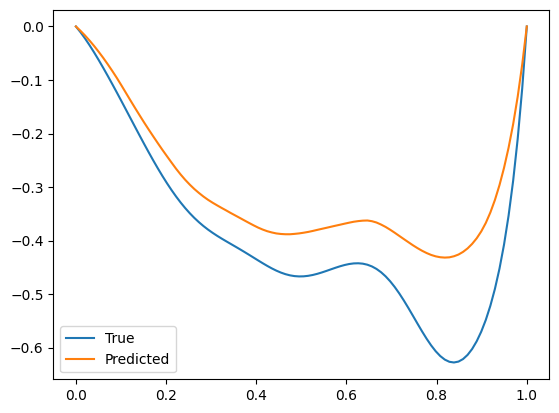

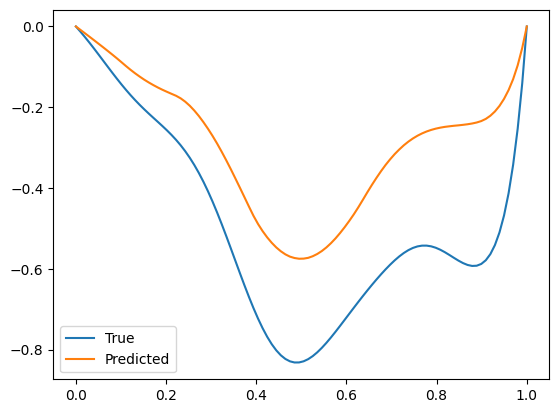

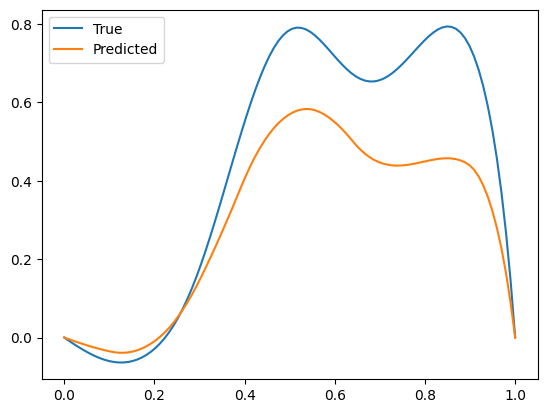

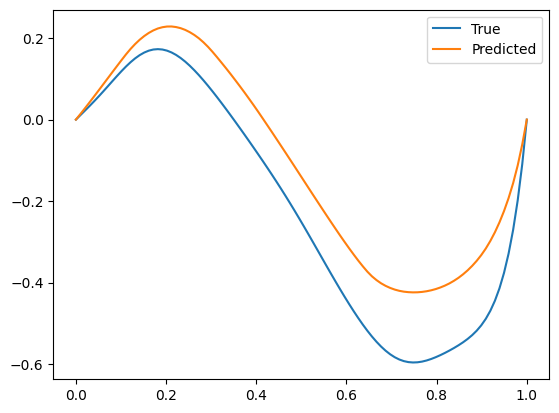

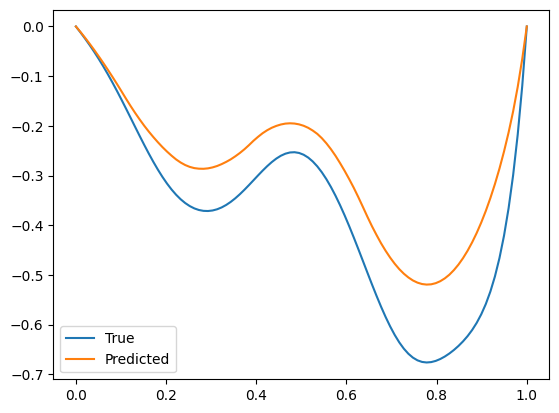

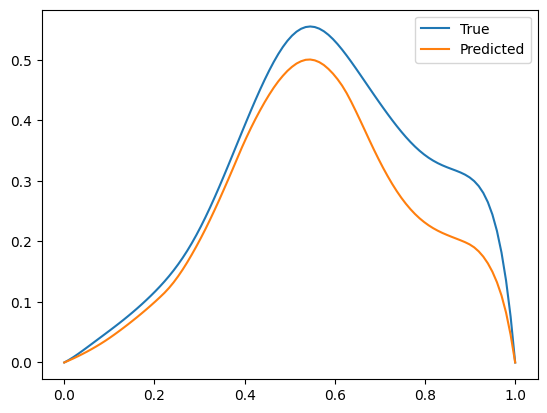

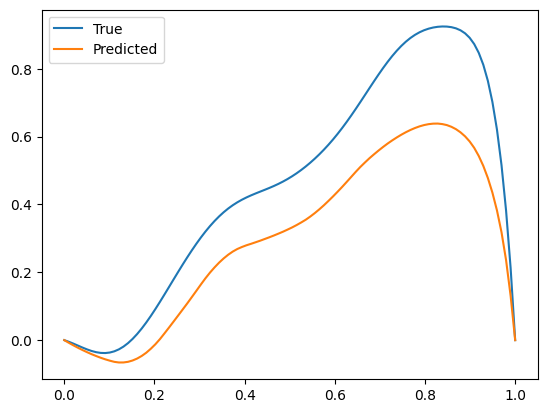

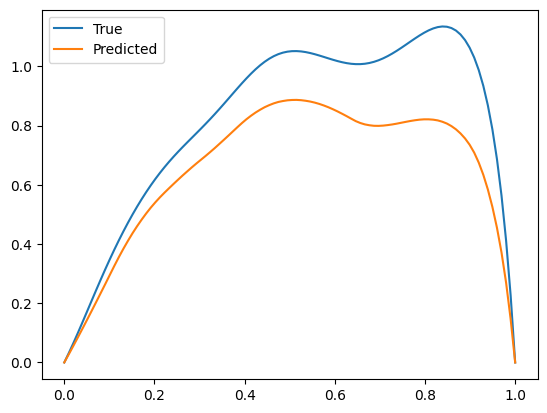

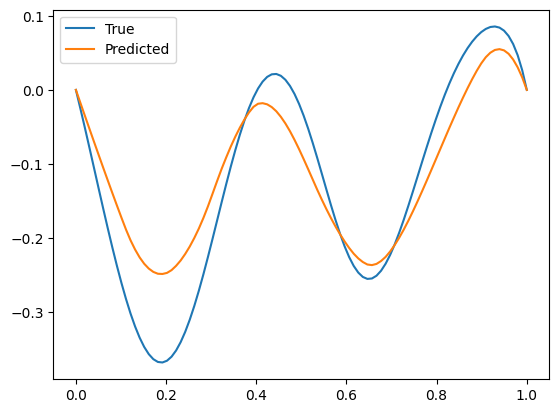

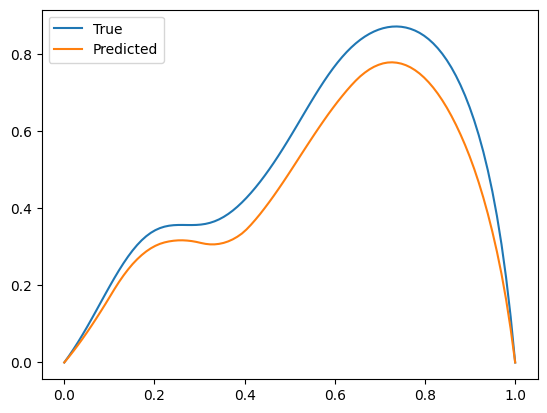

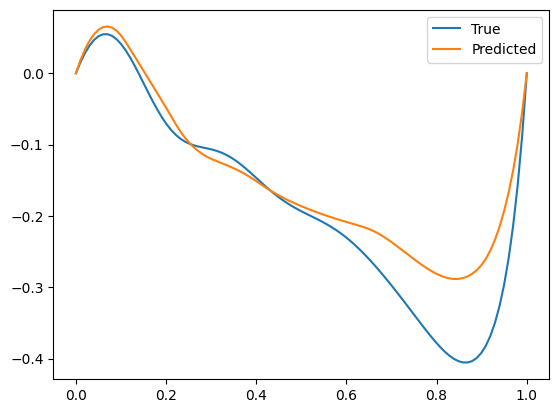

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:28:38,450 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:28:38,451 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.009645
2025-08-05 21:28:38,452 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.009345
Training progress:  10%|█         | 1/10 [00:02<00:26,  2.96s/it]2025-08-05 21:28:40,891 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:28:40,892 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008689
2025-08-05 21:28:40,893 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007630
Training progress:  20%|██        | 2/10 [00:05<00:21,  2.66s/it]2025-08-05 21:28:43,458 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:28:43,460 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.007710
2025-08-05 21:28:43,461 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007702
Training progress:  30%|███       | 3/10 [00:07<00:18,  2.62s/i

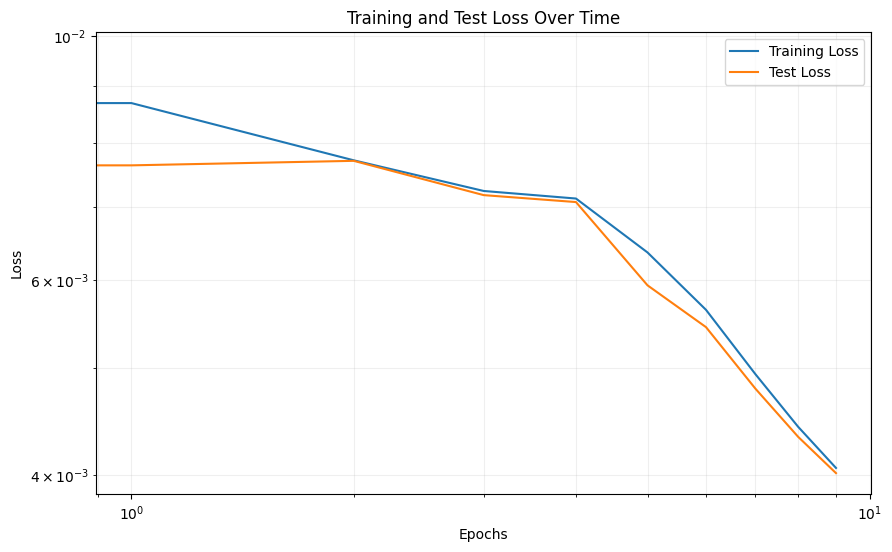

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


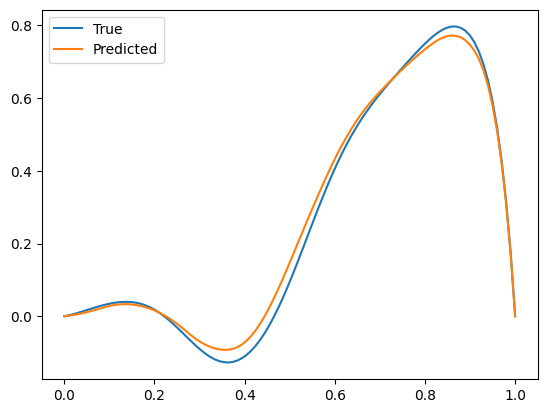

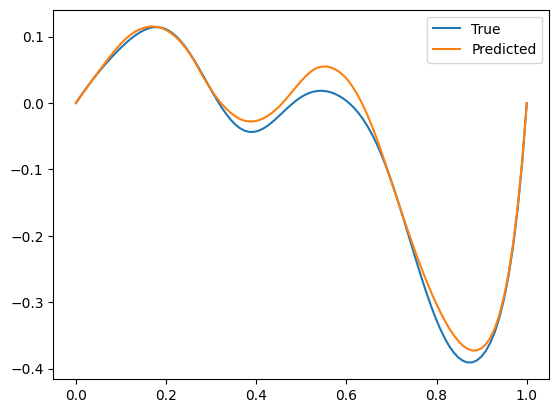

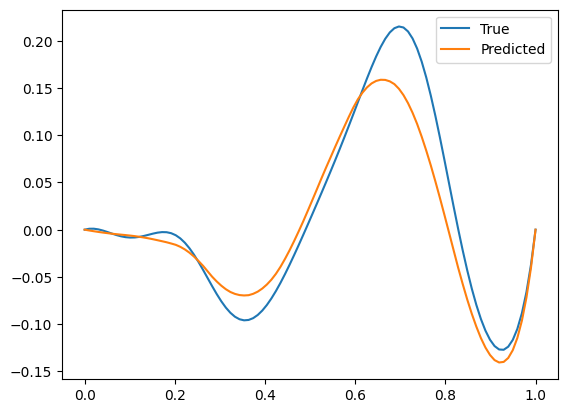

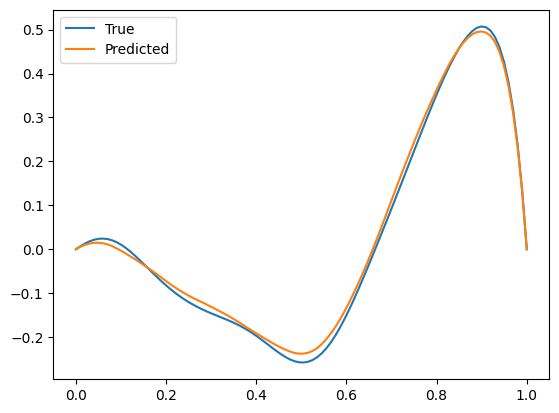

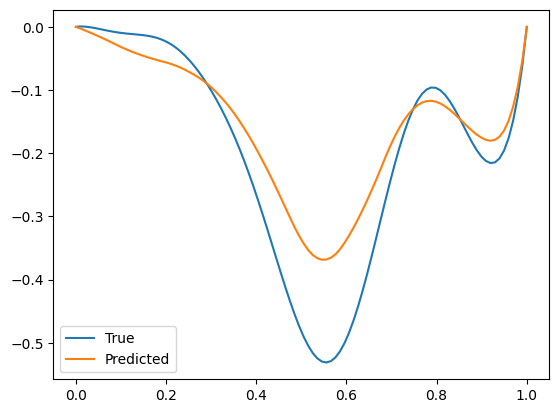

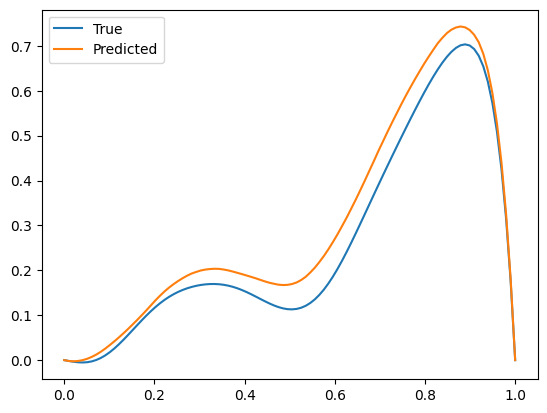

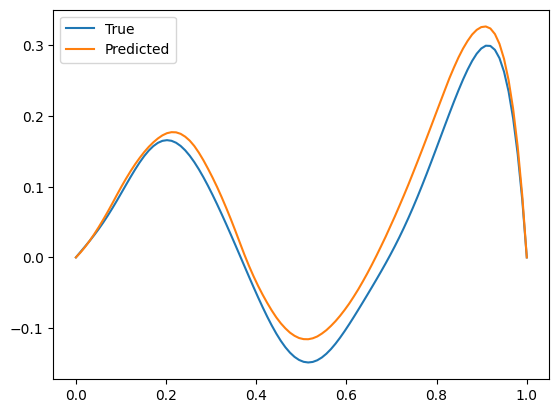

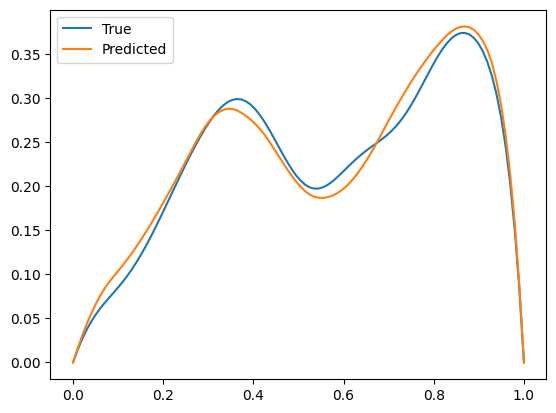

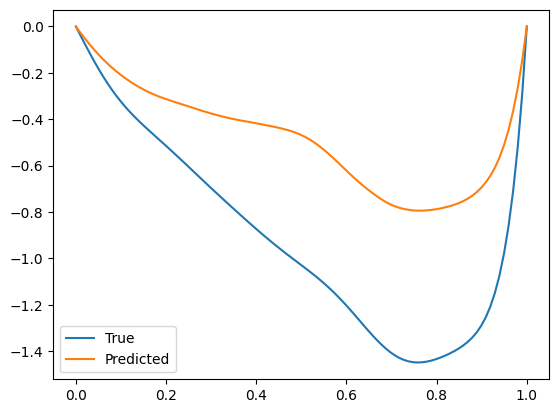

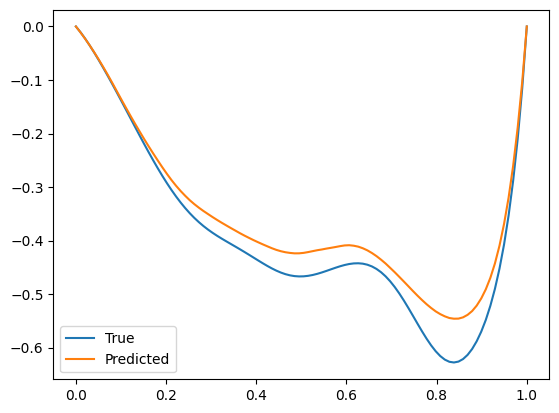

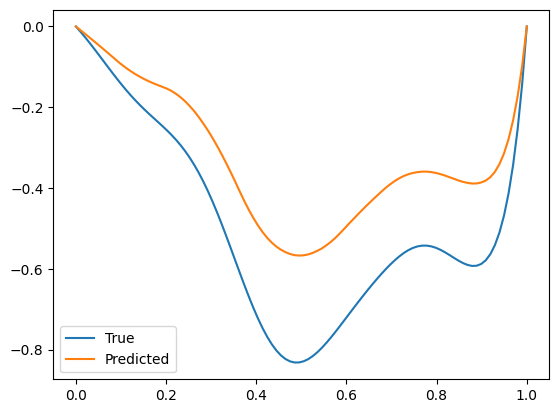

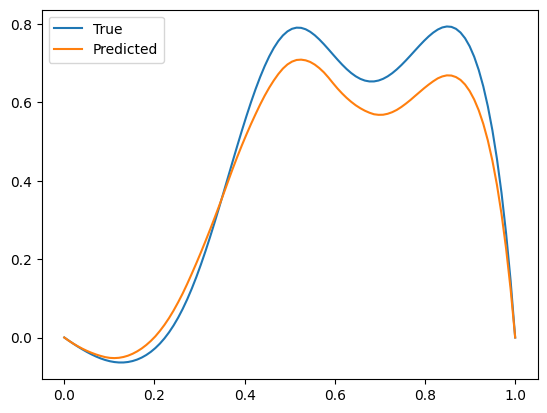

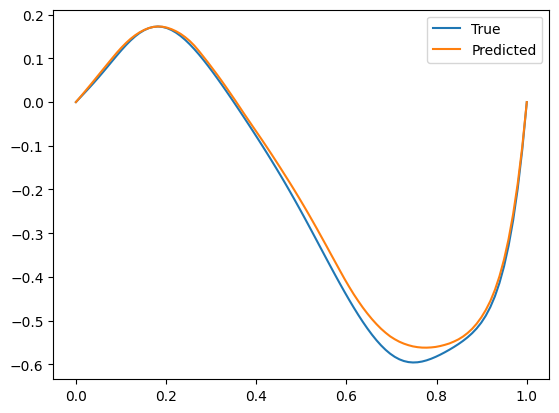

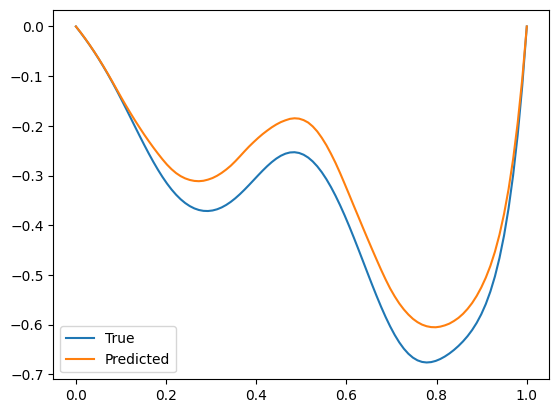

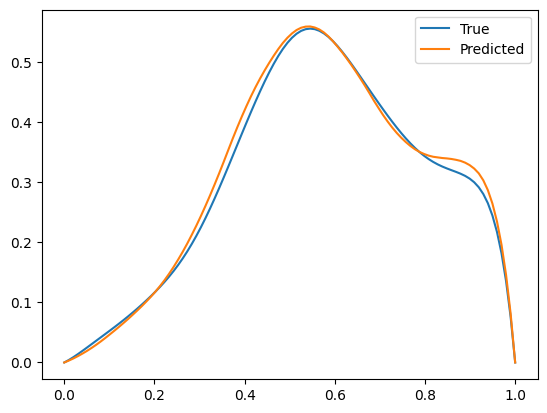

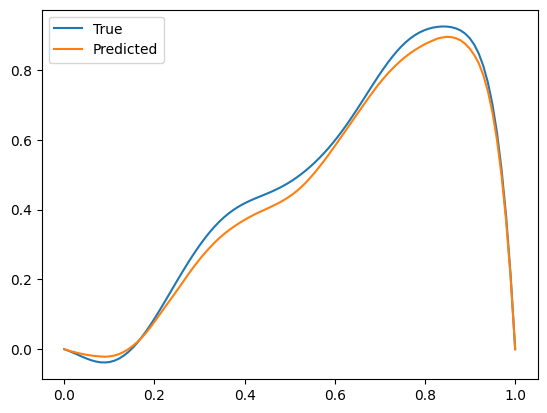

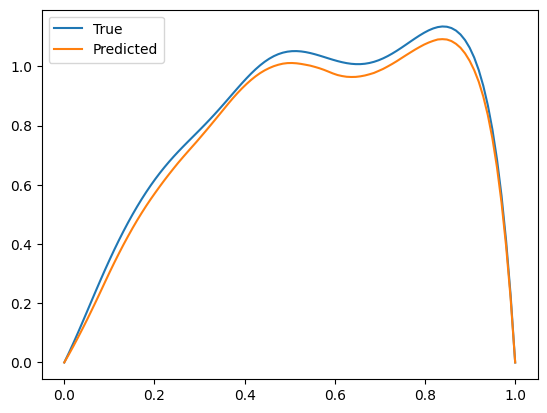

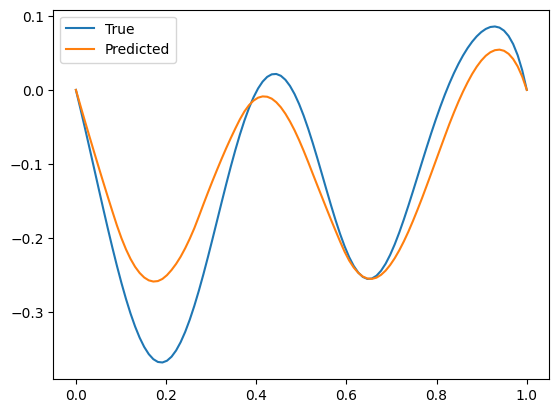

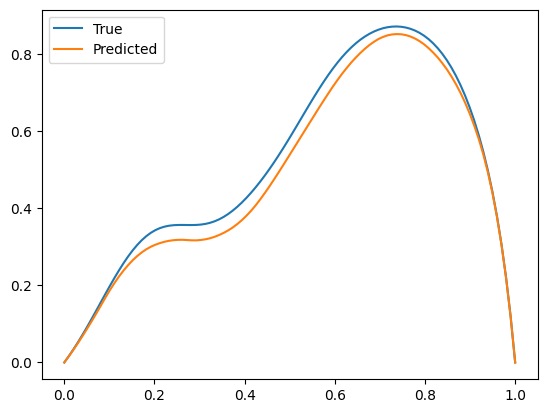

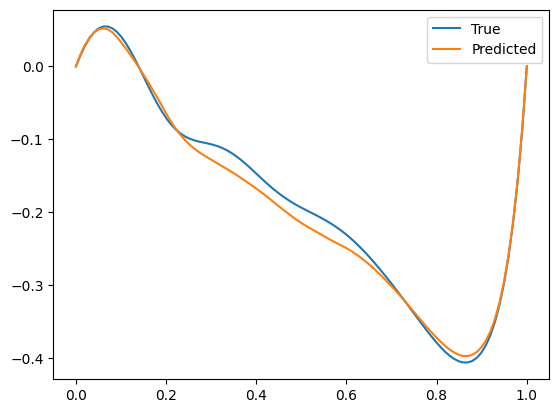

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:29:07,998 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:29:07,999 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003824
2025-08-05 21:29:08,001 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003910
Training progress:  10%|█         | 1/10 [00:03<00:28,  3.12s/it]2025-08-05 21:29:10,255 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:29:10,256 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003658
2025-08-05 21:29:10,256 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003665
Training progress:  20%|██        | 2/10 [00:05<00:20,  2.61s/it]2025-08-05 21:29:12,497 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:29:12,497 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003426
2025-08-05 21:29:12,498 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003462
Training progress:  30%|███       | 3/10 [00:07<00:17,  2.44s/i

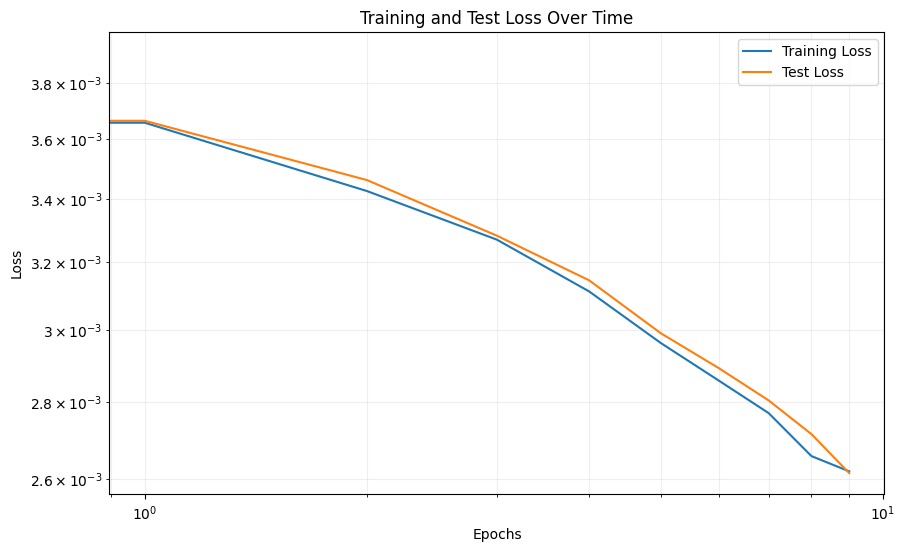

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


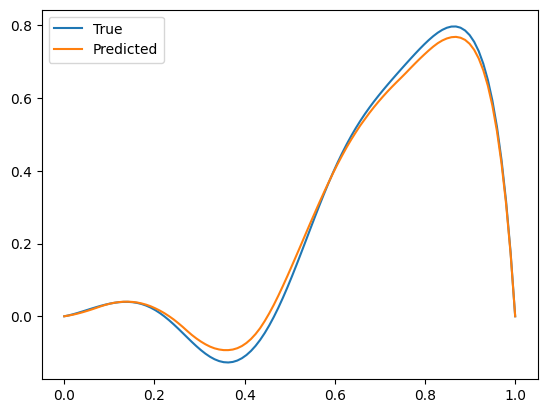

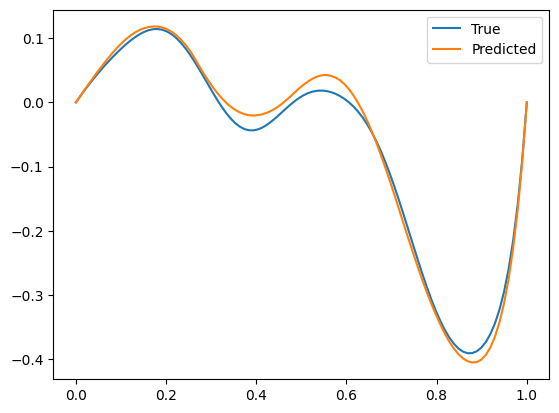

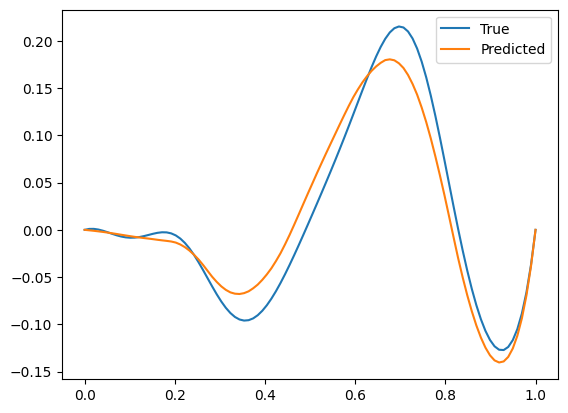

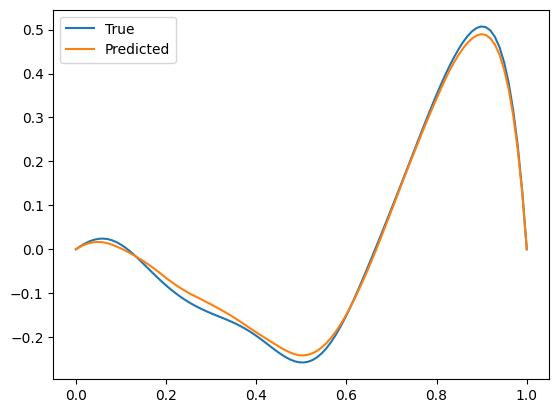

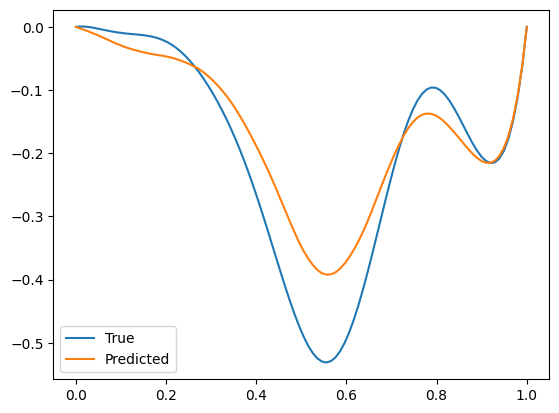

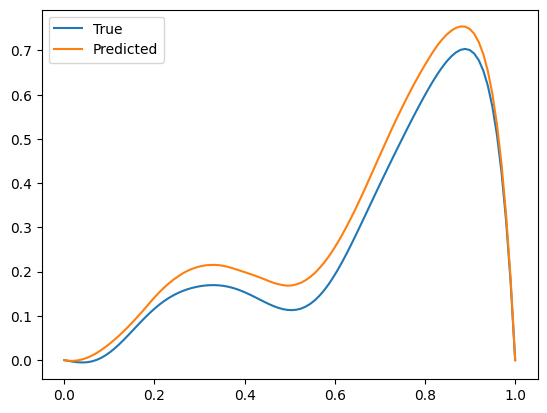

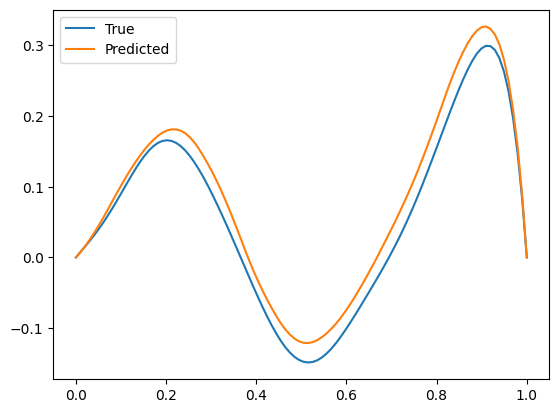

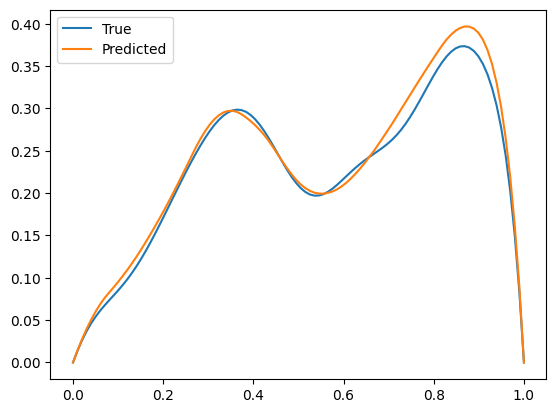

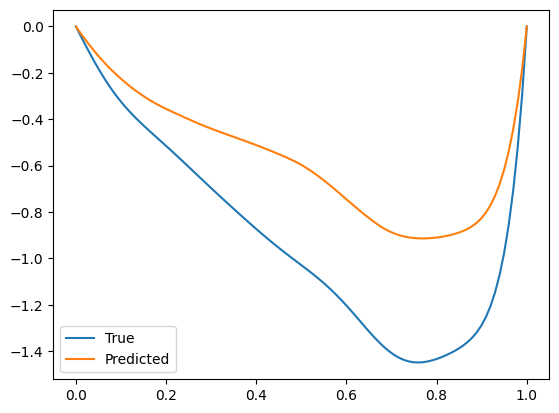

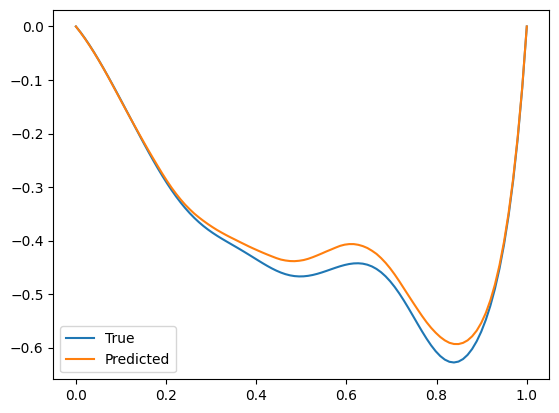

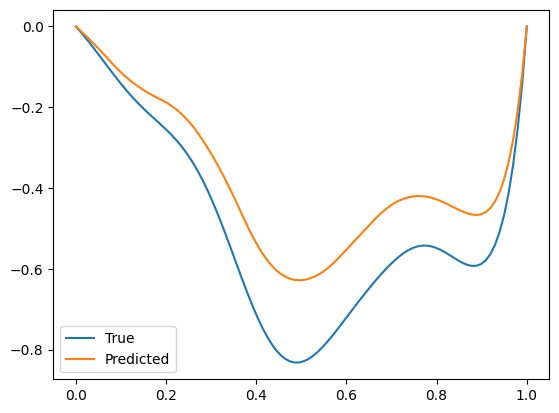

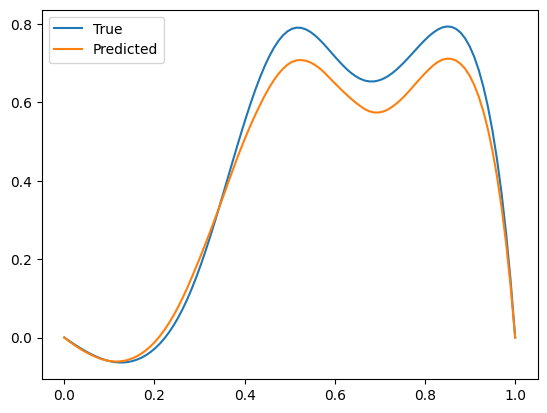

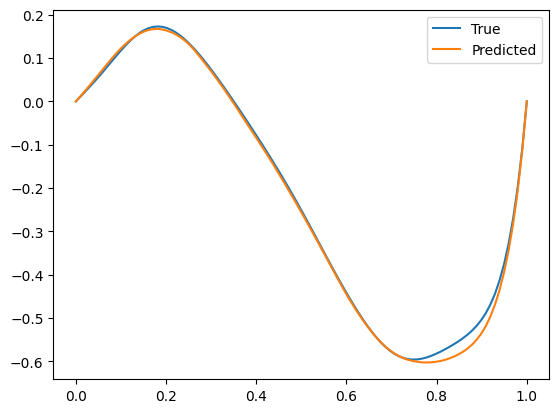

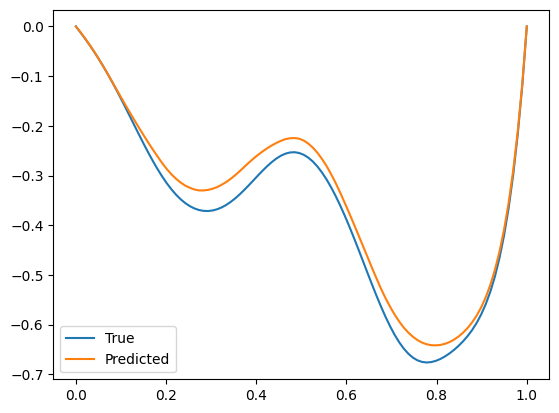

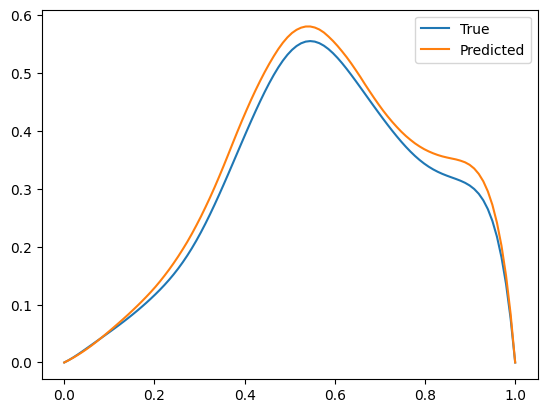

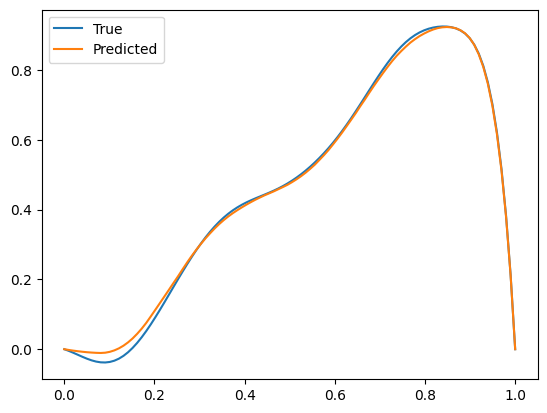

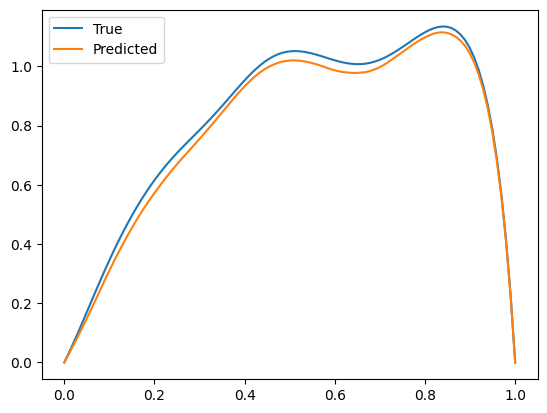

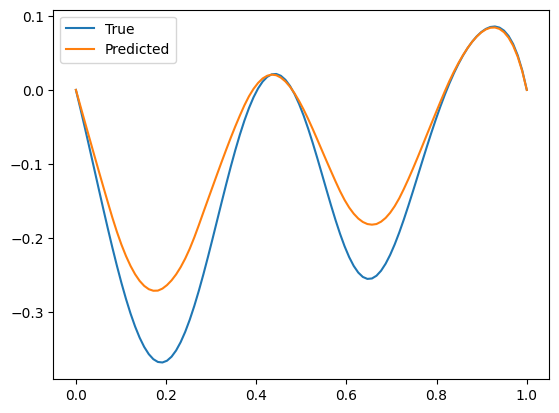

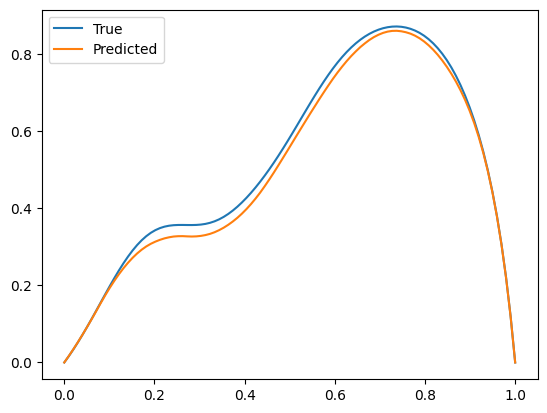

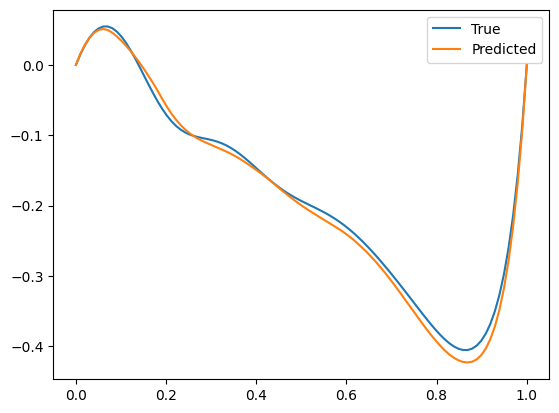

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:29:36.873504: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-05 21:29:37,028 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:29:37,029 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002517
2025-08-05 21:29:37,030 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002561
Training progress:  10%|█         | 1/10 [00:03<00:28,  3.20s/it]2025-08-05 21:29:39,537 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:29:39,538 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002489
2025-08-05 21:29:39,539 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002580
Training progress:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]2025-08-05 21:29:42,039 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:29:42,040 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.00

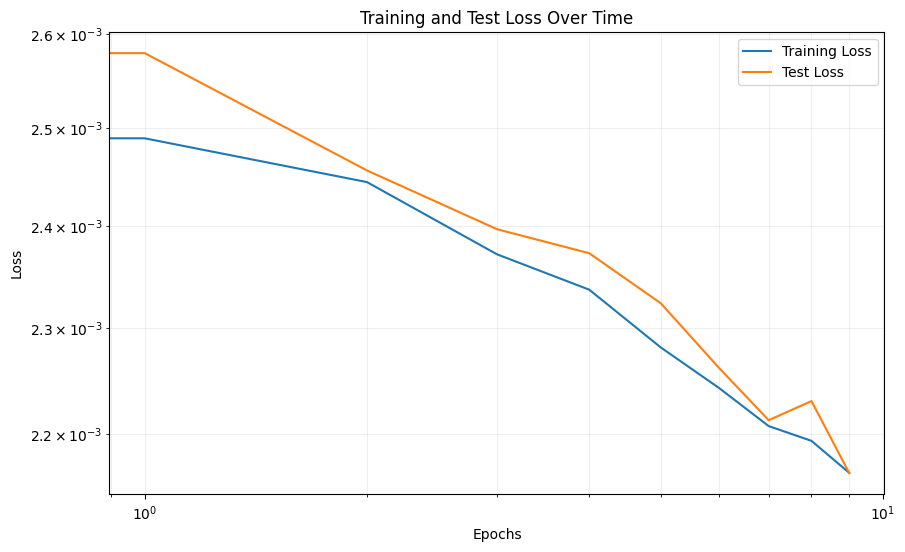

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


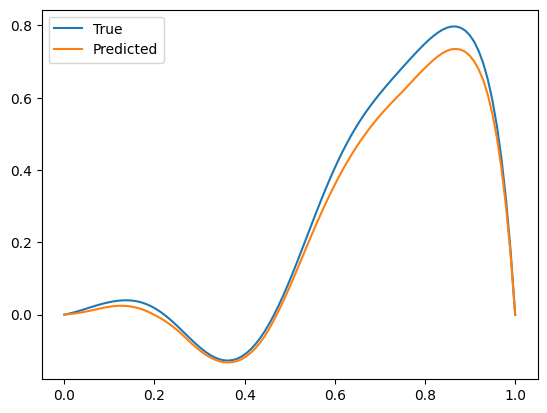

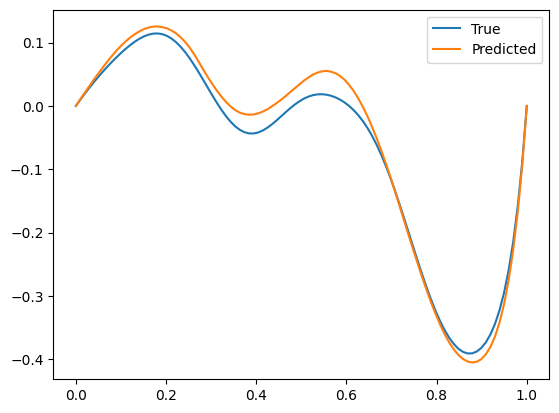

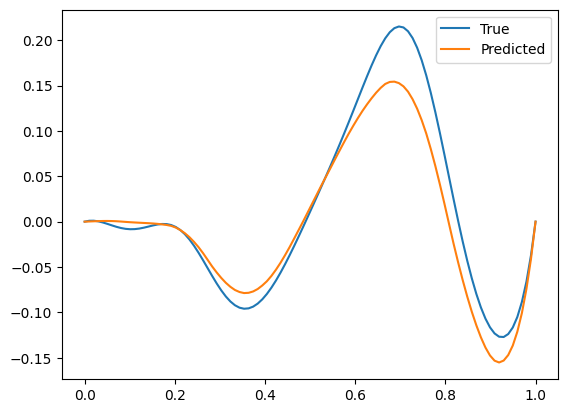

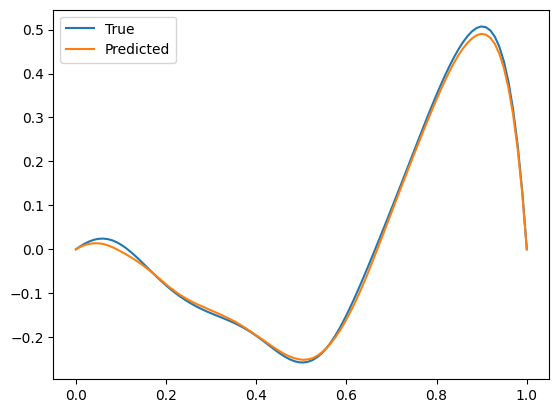

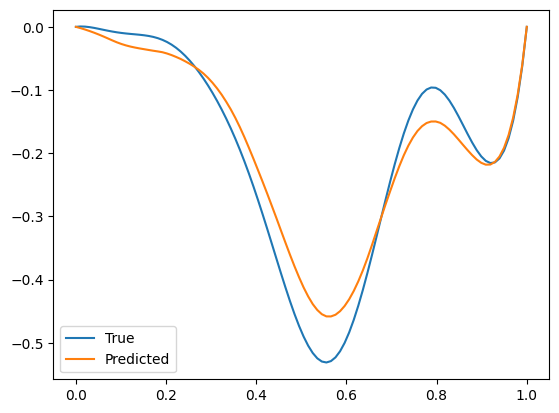

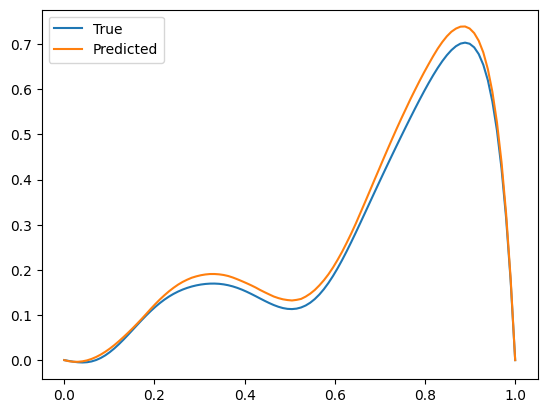

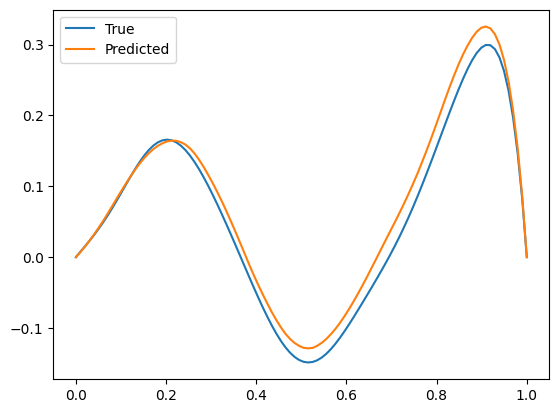

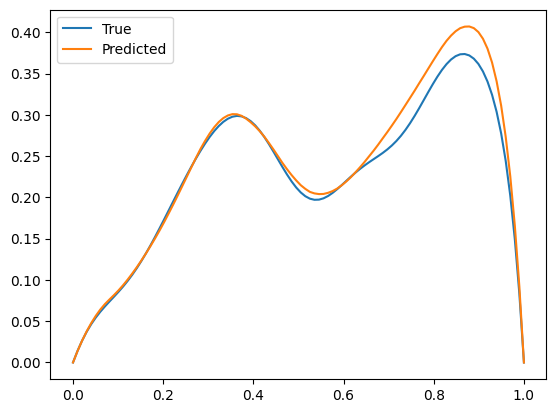

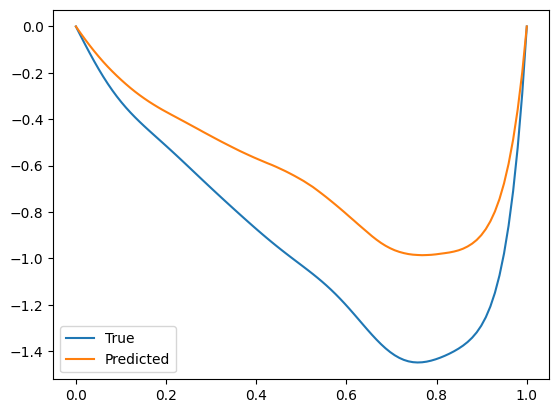

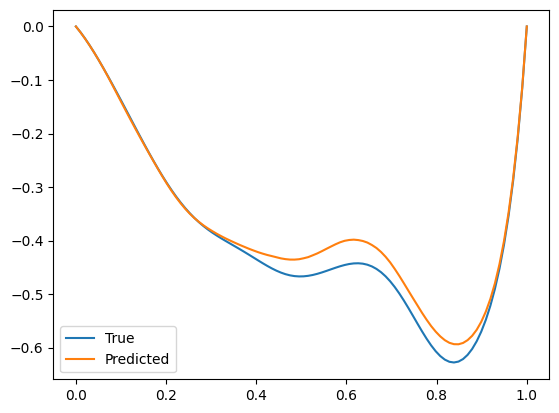

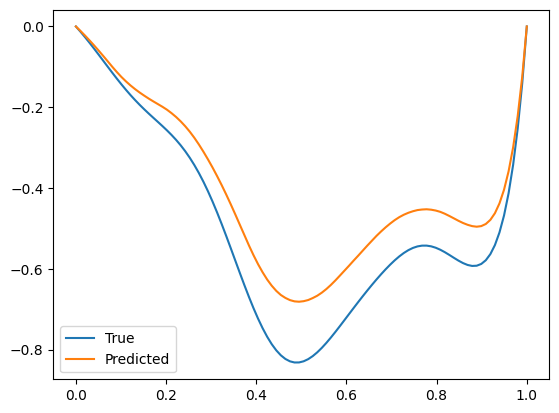

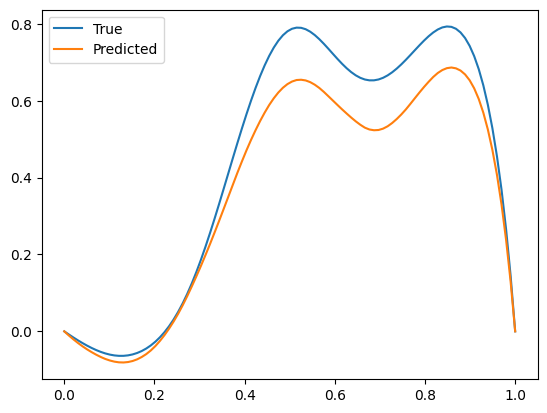

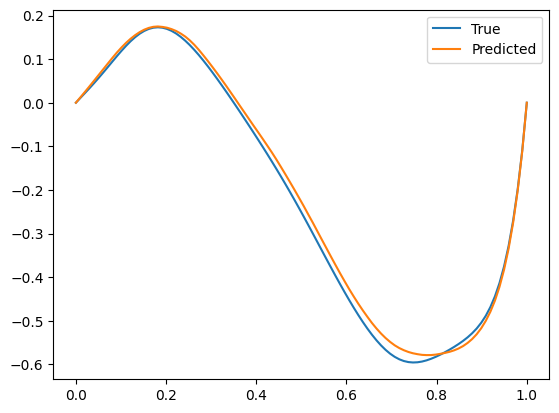

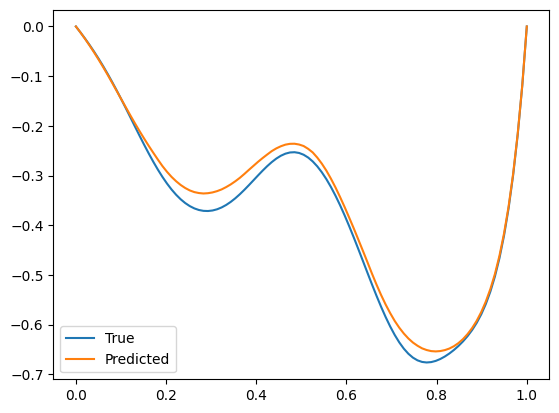

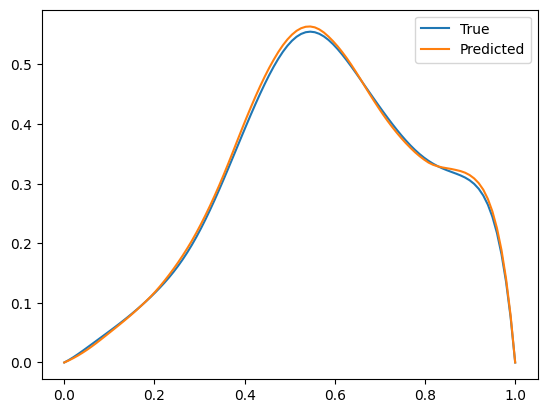

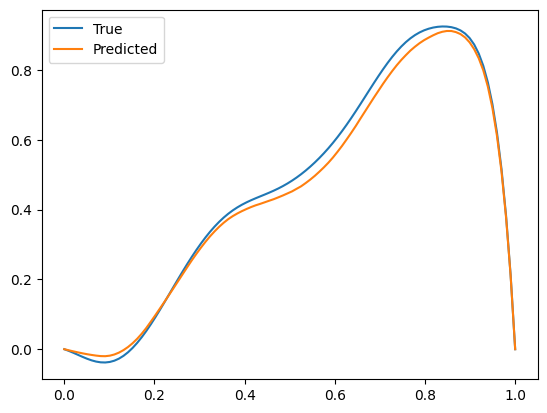

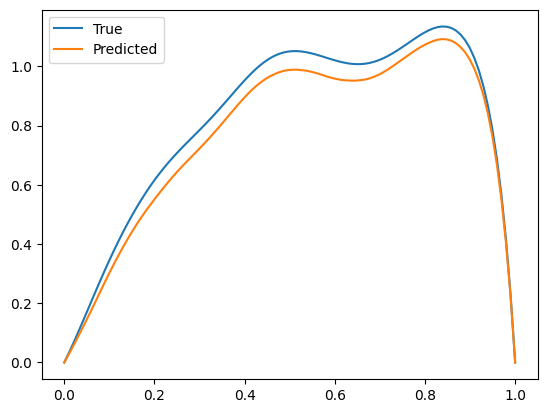

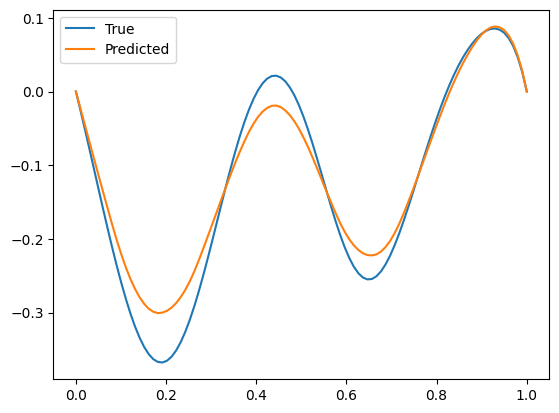

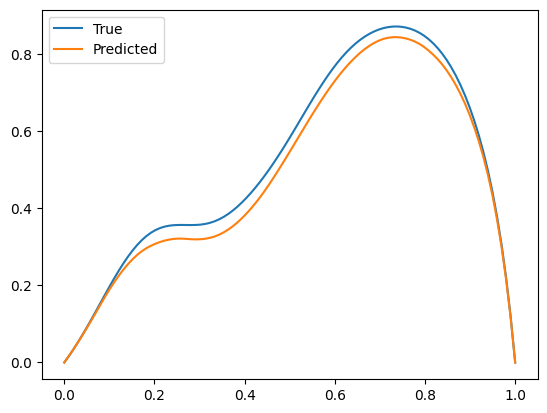

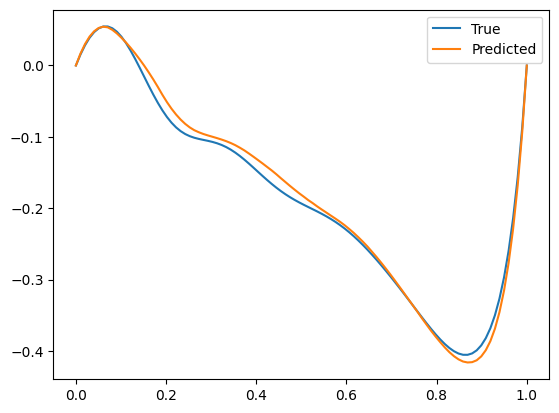

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:30:04,903 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:30:04,904 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002112
2025-08-05 21:30:04,905 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002051
Training progress:  10%|█         | 1/10 [00:03<00:29,  3.30s/it]2025-08-05 21:30:08,923 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:30:08,924 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002039
2025-08-05 21:30:08,925 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002061
Training progress:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]2025-08-05 21:30:11,561 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:30:11,562 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002025
2025-08-05 21:30:11,563 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002031
Training progress:  30%|███       | 3/10 [00:09<00:22,  3.23s/i

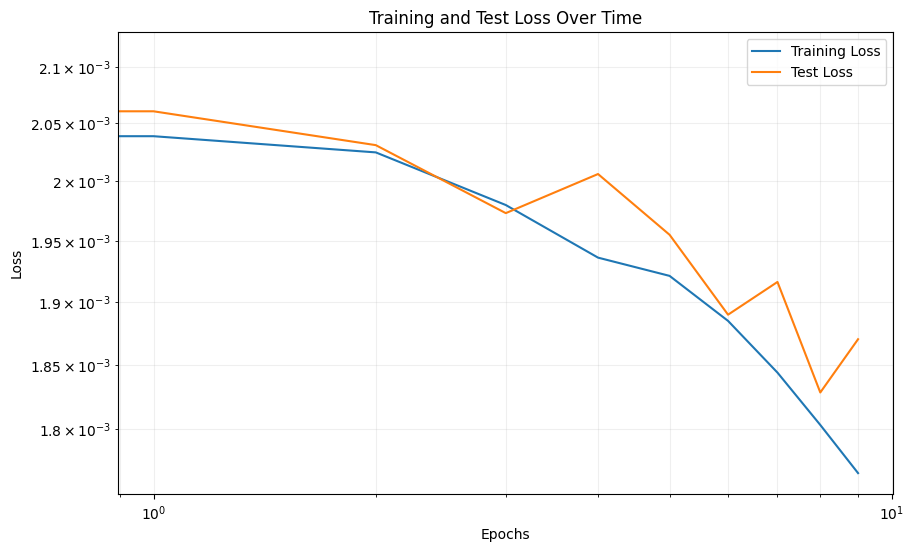

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


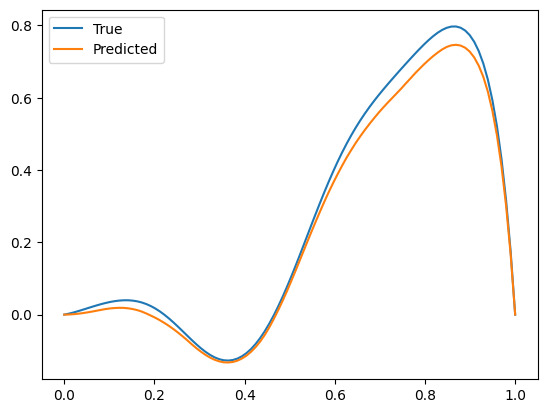

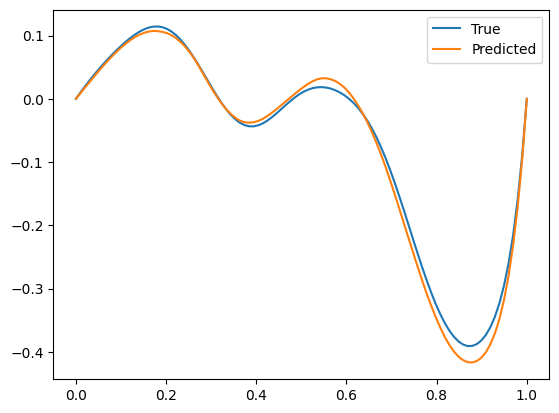

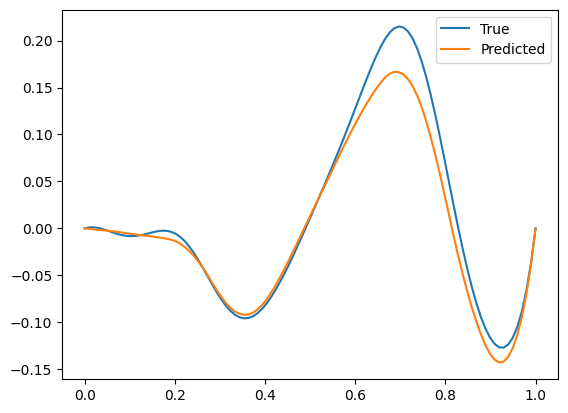

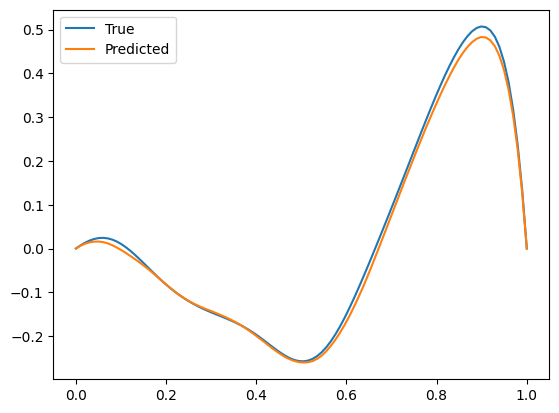

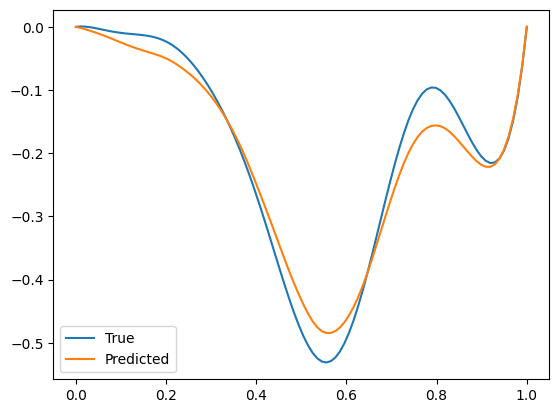

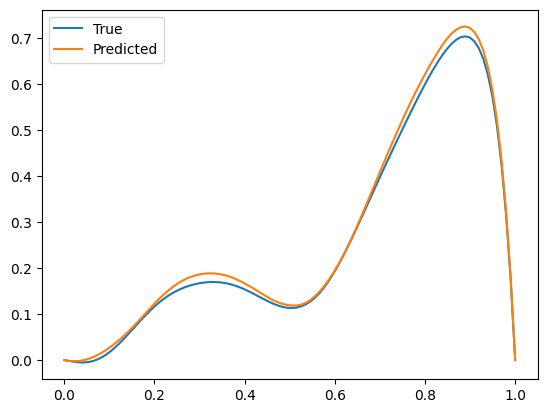

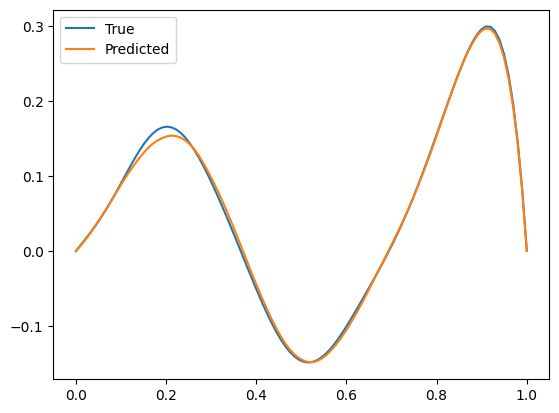

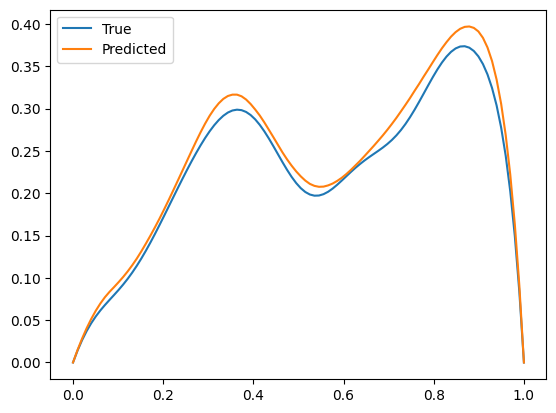

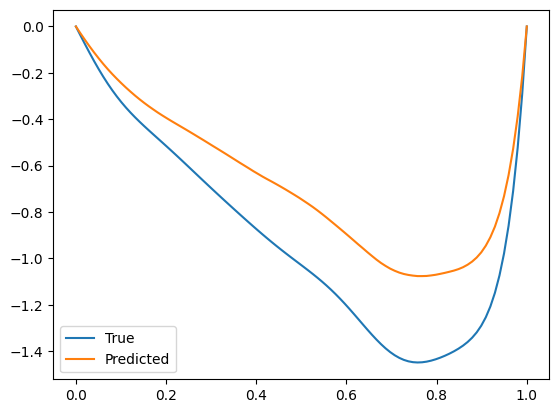

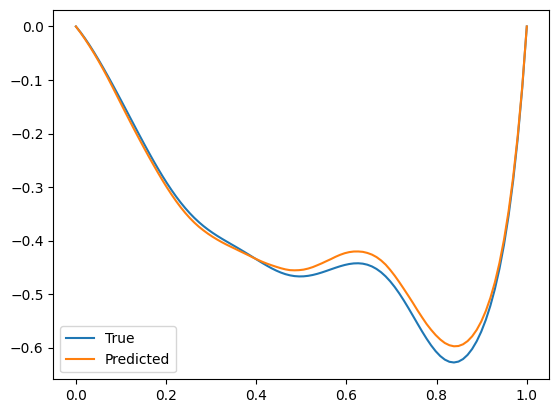

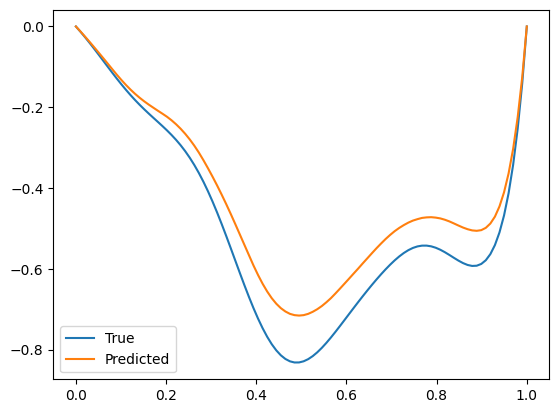

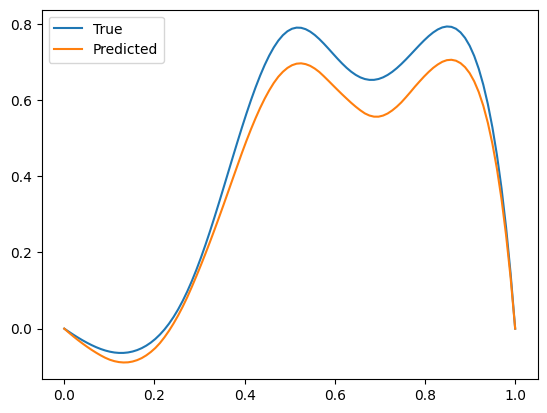

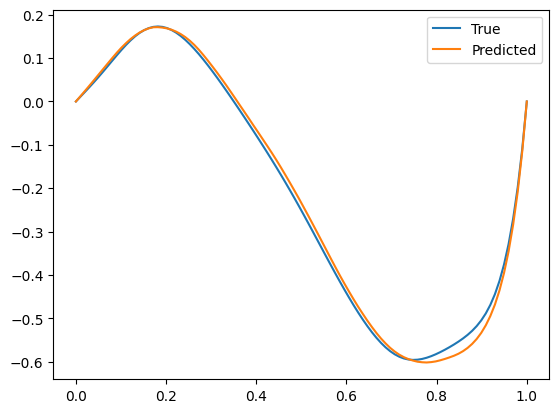

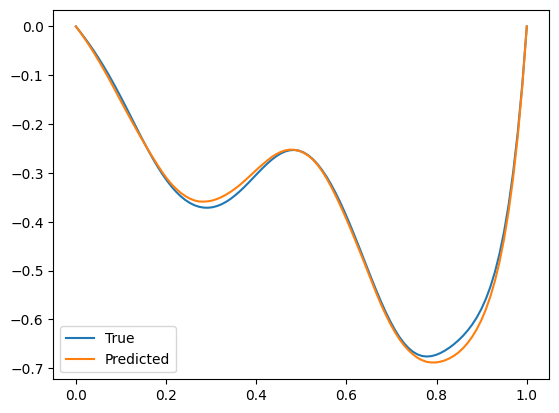

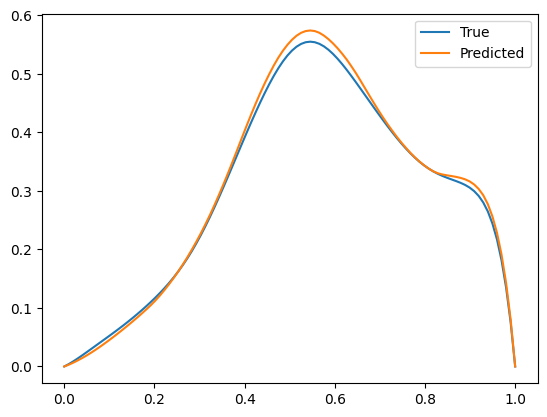

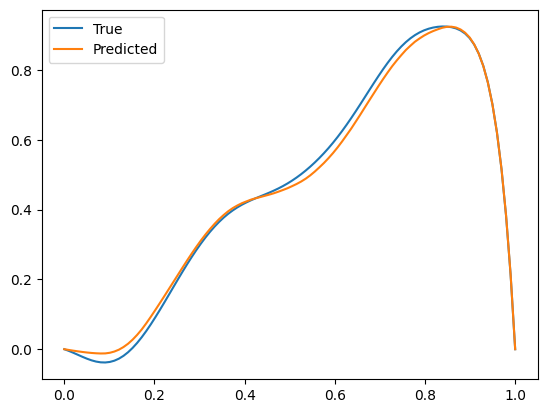

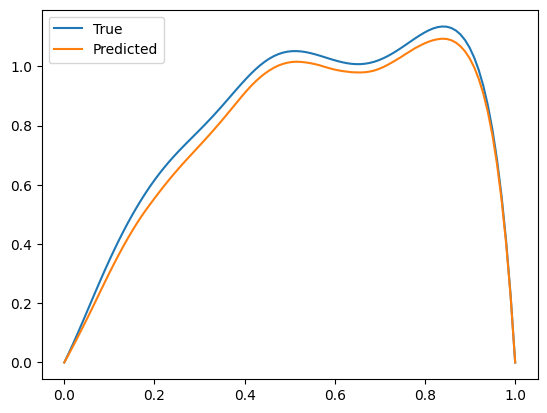

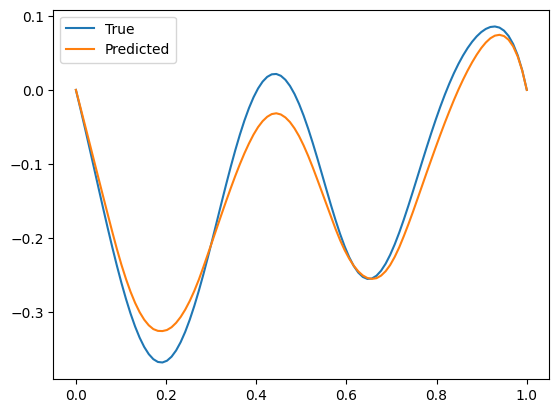

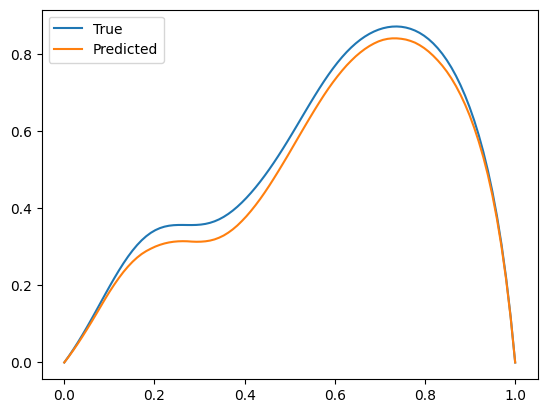

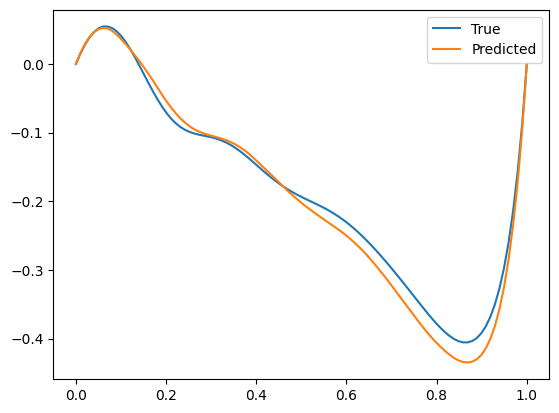

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:30:34,591 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:30:34,592 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.001743
2025-08-05 21:30:34,593 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.001861
Training progress:  10%|█         | 1/10 [00:03<00:28,  3.12s/it]2025-08-05 21:30:37,052 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:30:37,053 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.001692
2025-08-05 21:30:37,053 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.001721
Training progress:  20%|██        | 2/10 [00:05<00:21,  2.73s/it]2025-08-05 21:30:40,946 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:30:40,947 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.001672
2025-08-05 21:30:40,947 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.001678
Training progress:  30%|███       | 3/10 [00:09<00:22,  3.26s/i

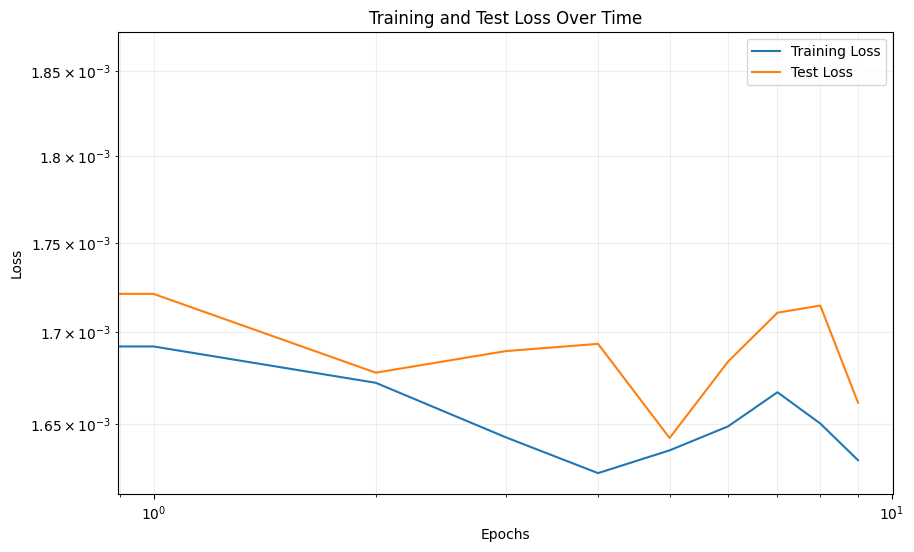

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


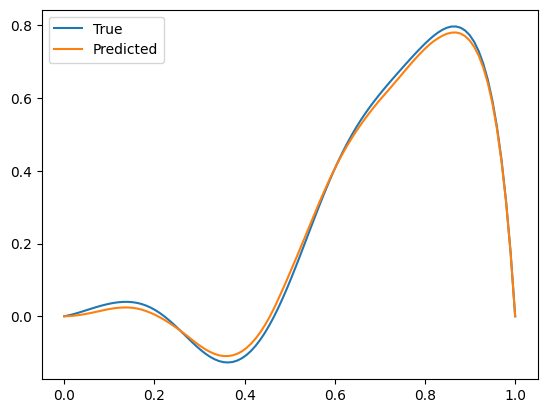

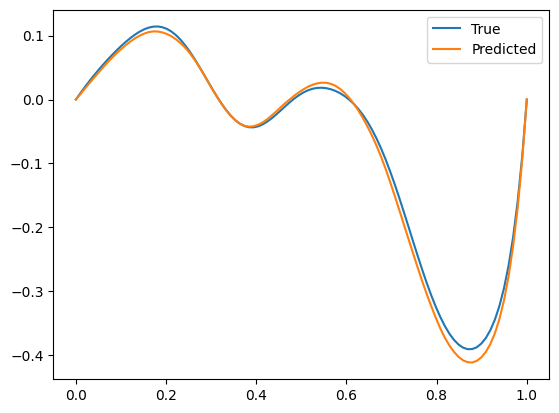

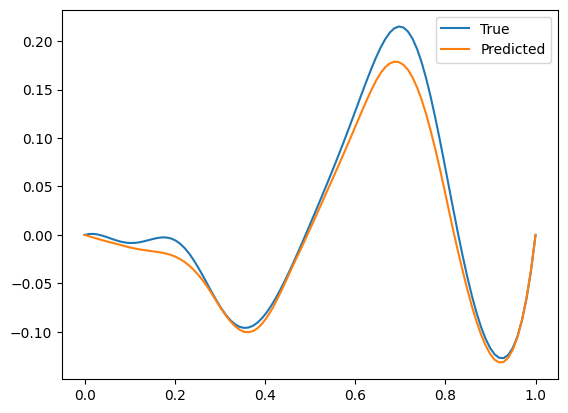

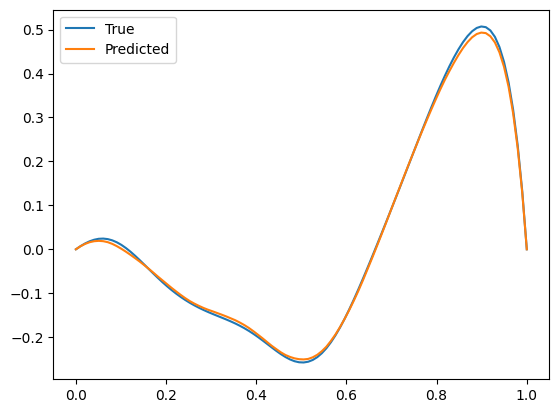

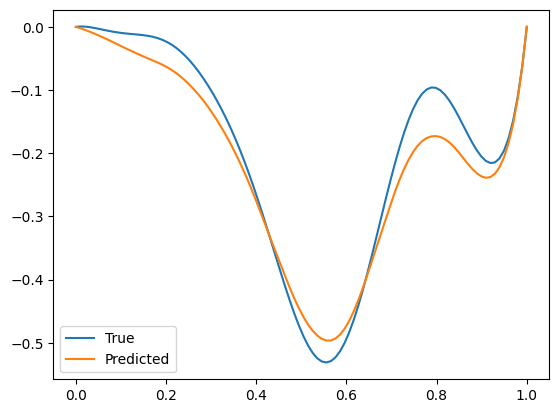

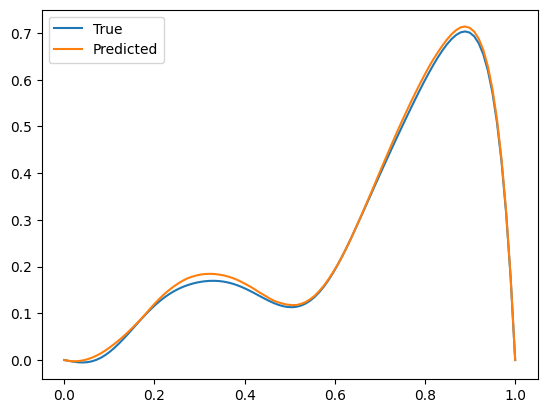

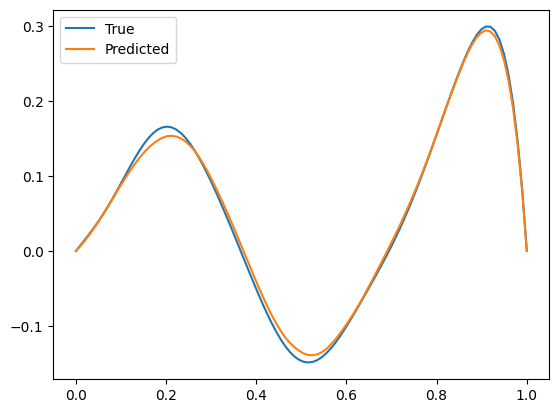

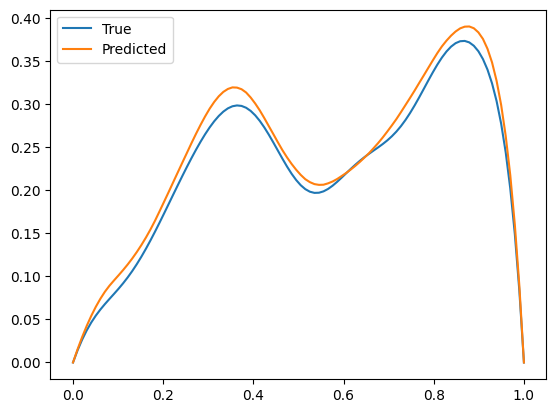

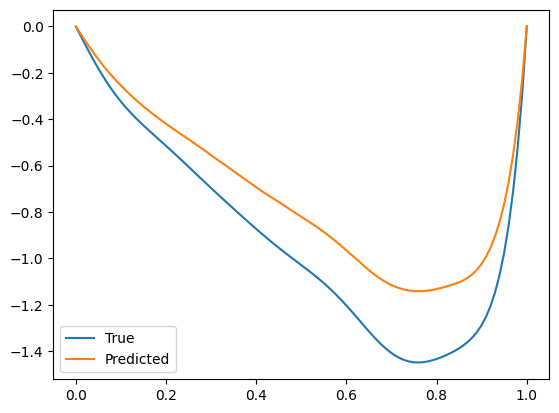

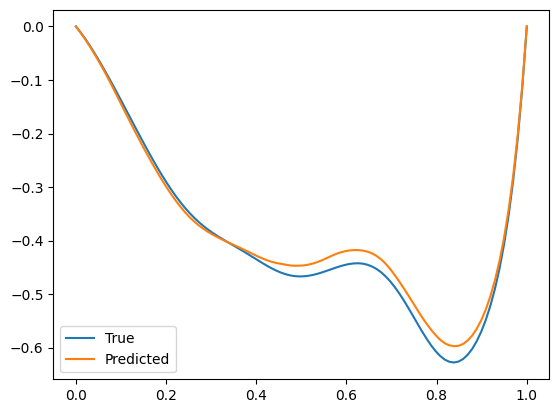

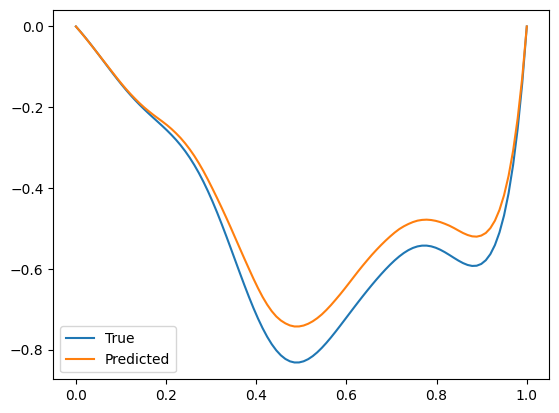

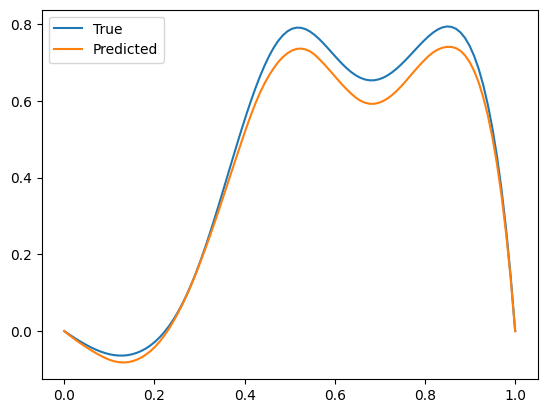

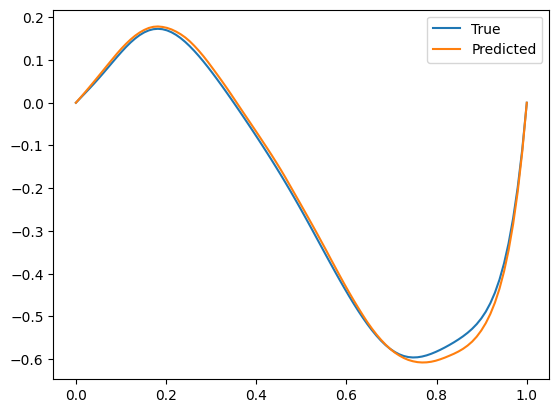

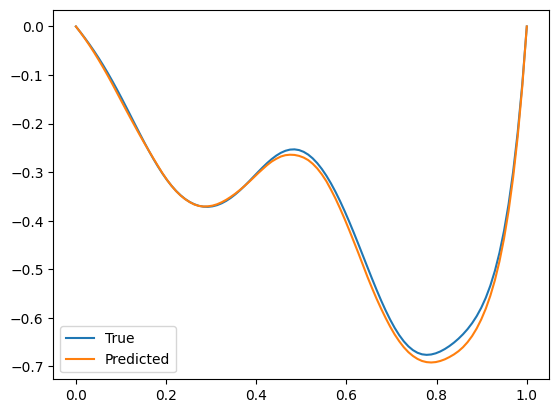

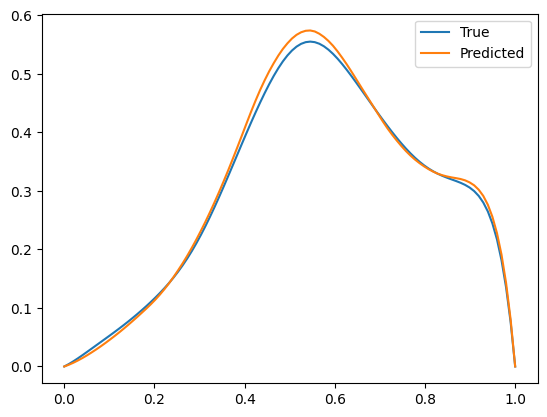

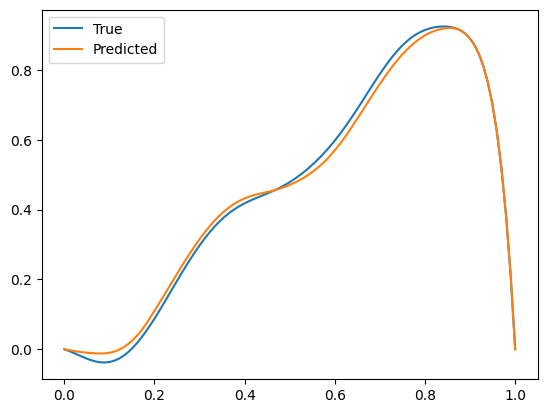

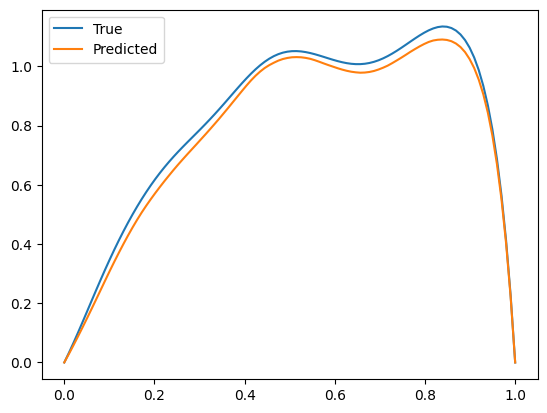

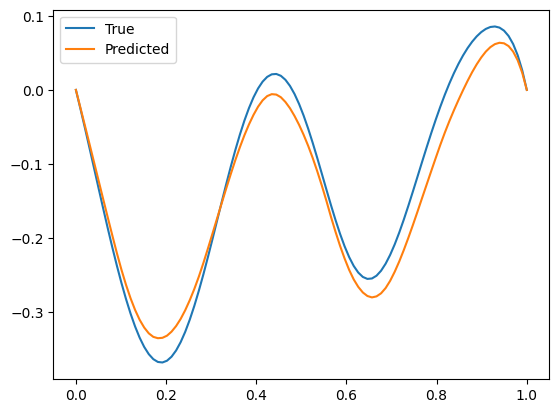

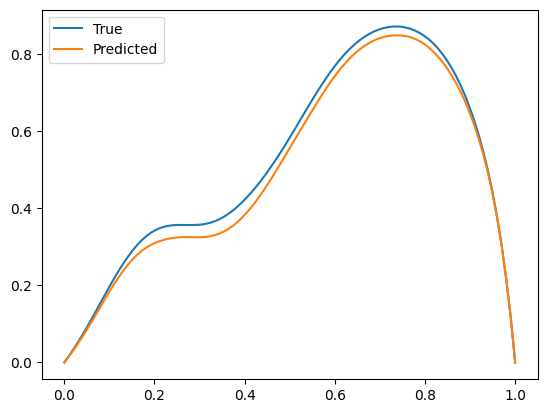

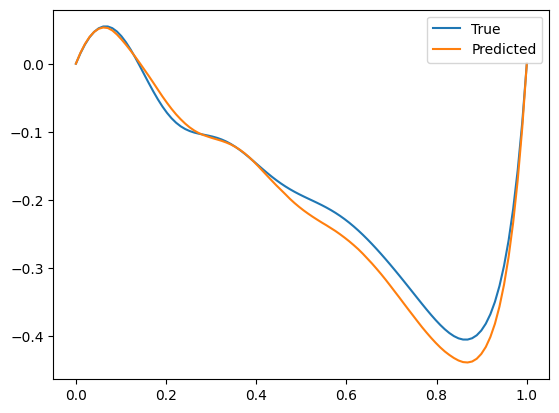

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-05 21:31:05,319 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-05 21:31:05,320 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.001586
2025-08-05 21:31:05,321 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.001628
Training progress:  10%|█         | 1/10 [00:03<00:31,  3.53s/it]2025-08-05 21:31:07,849 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-05 21:31:07,850 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.001552
2025-08-05 21:31:07,851 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.001603
Training progress:  20%|██        | 2/10 [00:06<00:23,  2.94s/it]2025-08-05 21:31:10,439 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-05 21:31:10,440 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.001563
2025-08-05 21:31:10,441 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.001622
Training progress:  30%|███       | 3/10 [00:08<00:19,  2.78s/i

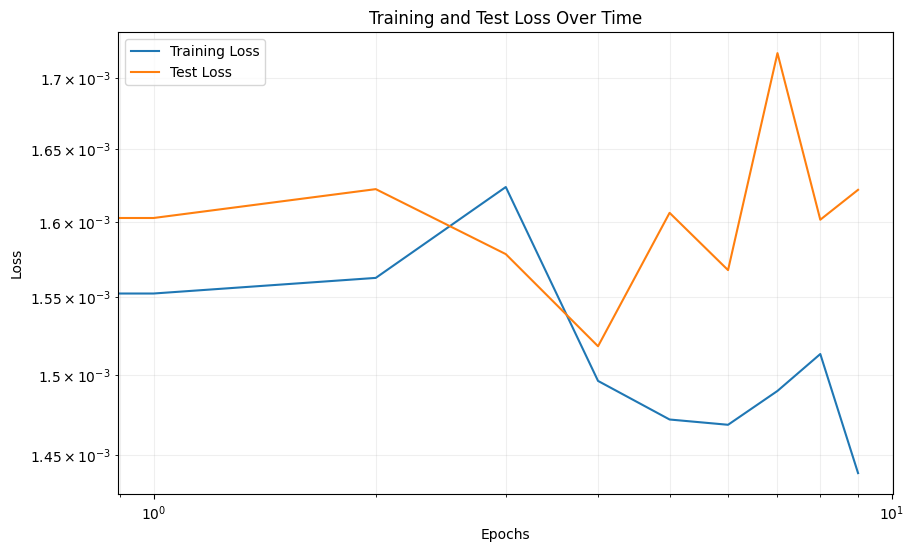

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


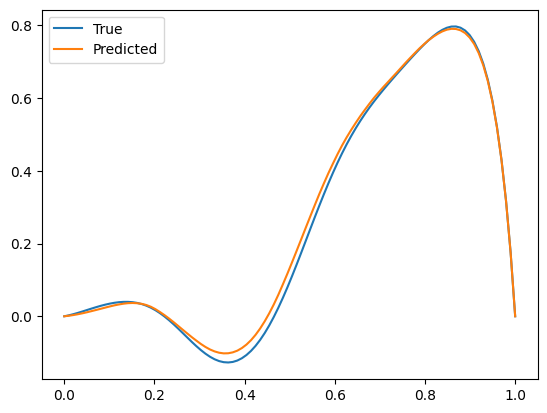

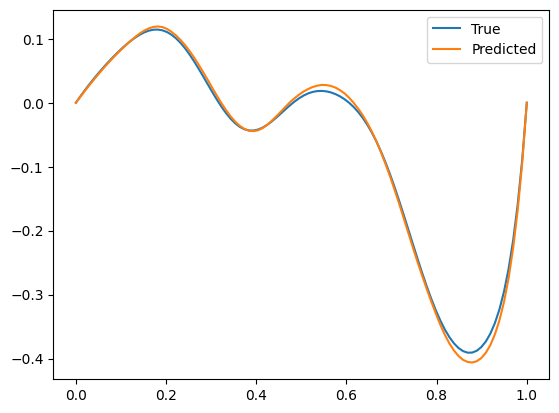

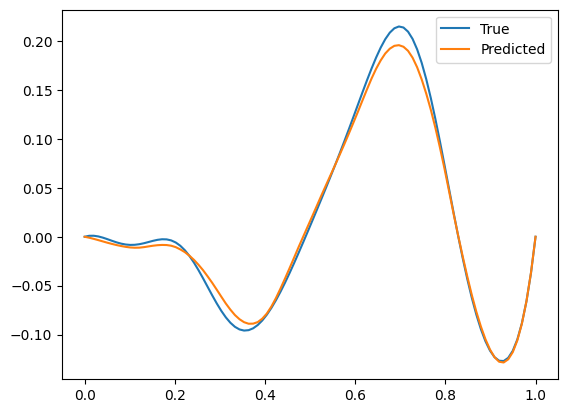

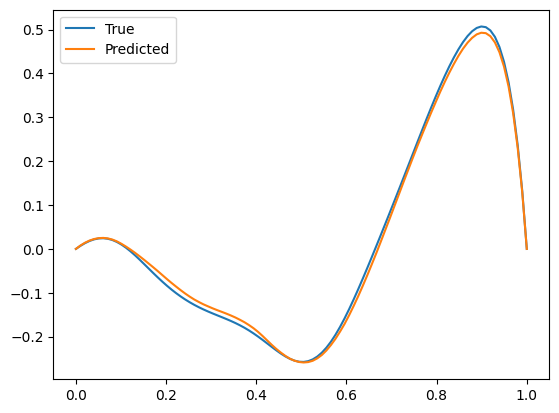

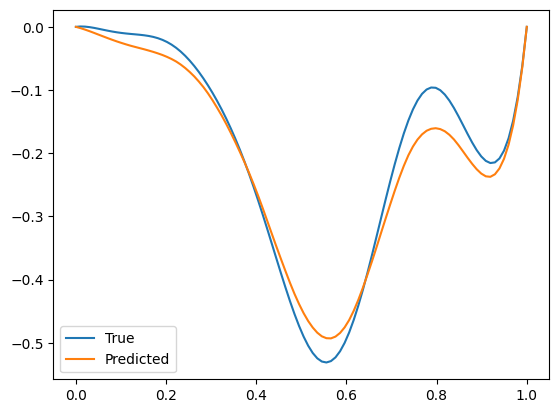

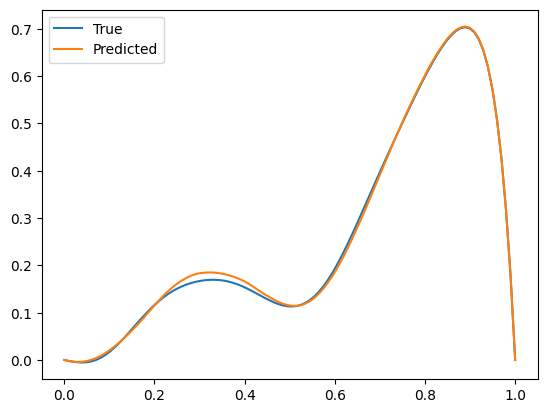

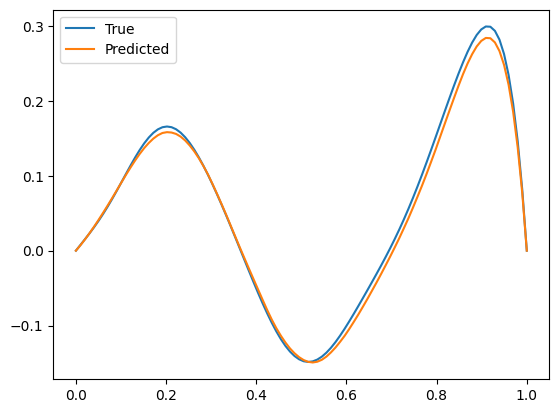

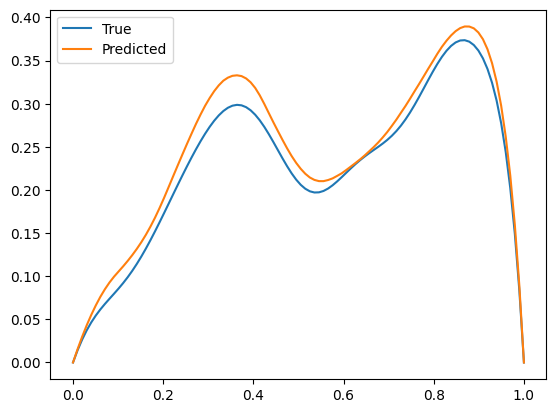

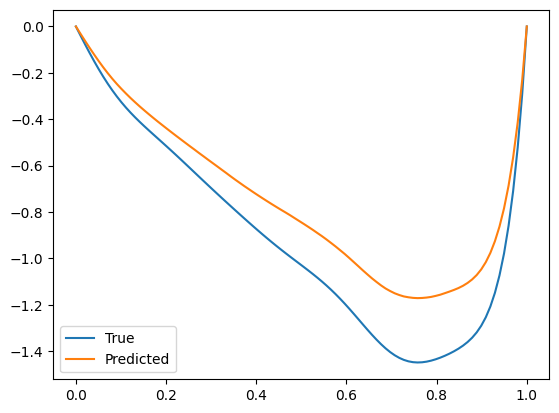

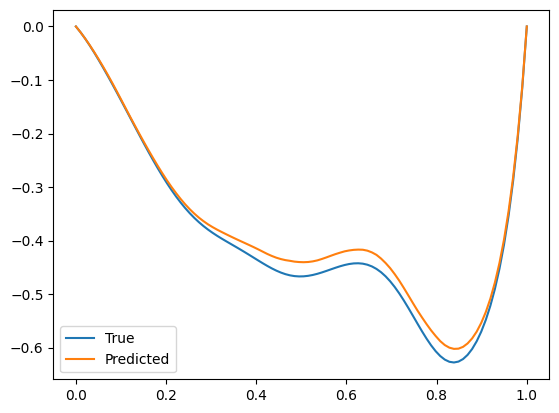

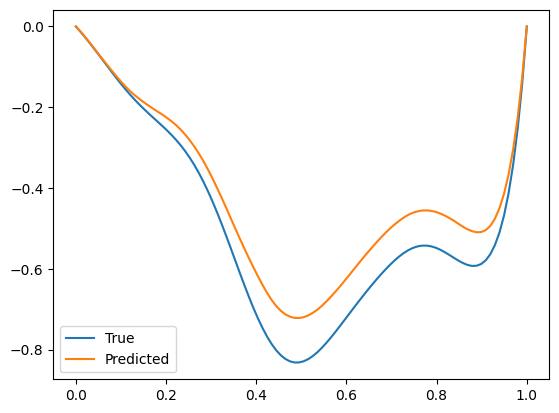

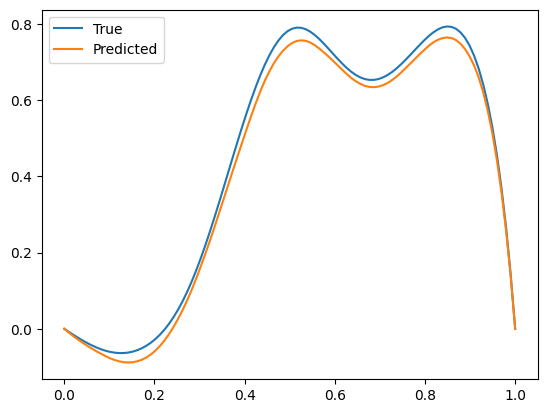

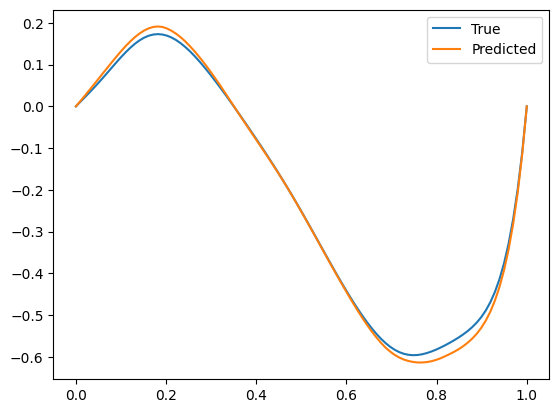

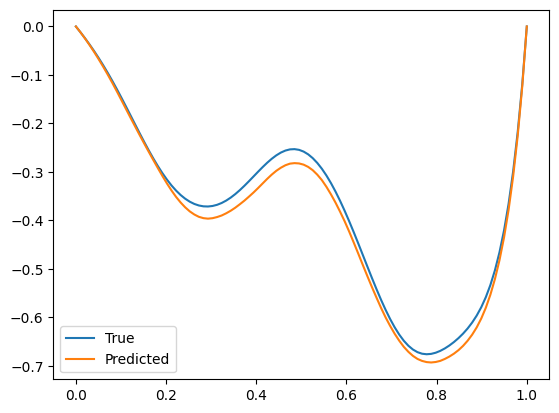

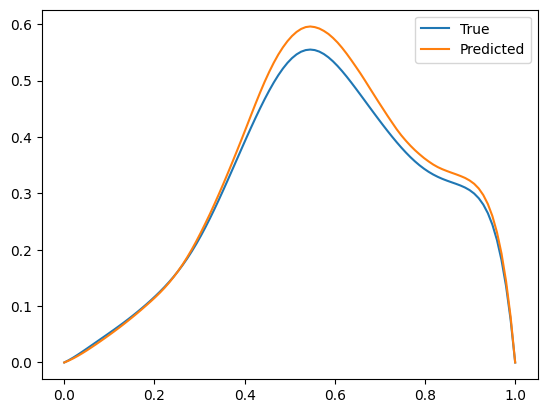

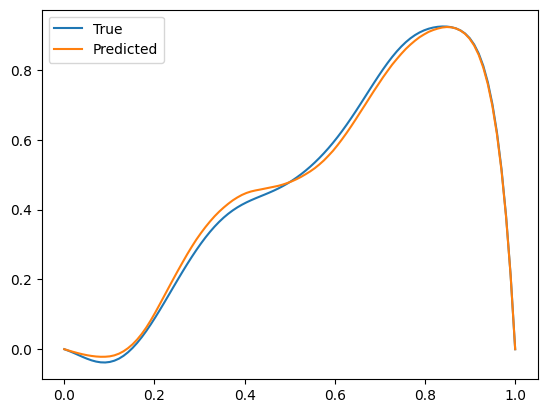

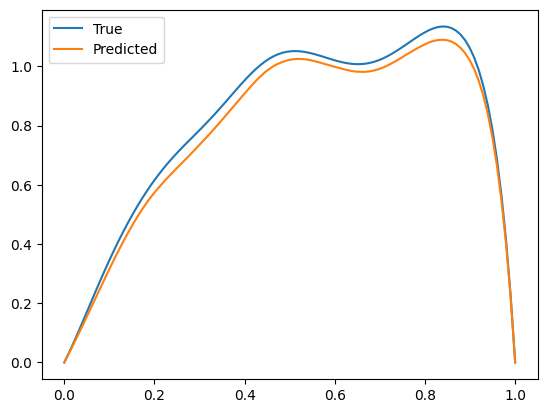

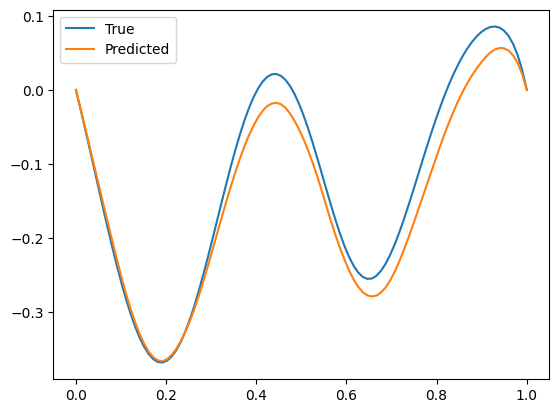

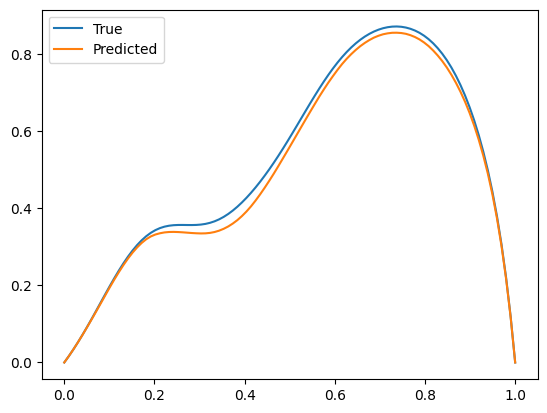

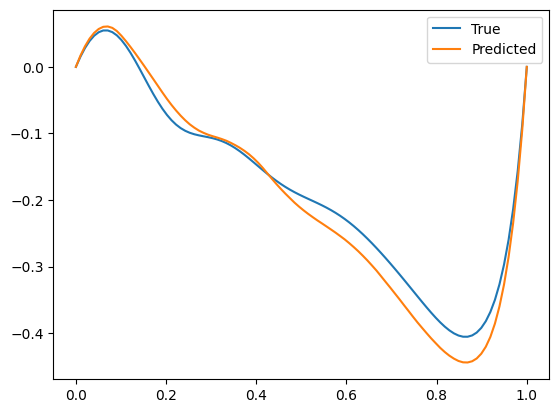

In [12]:
for _ in range(10):
    train_history = model.fit()
    plt.figure(figsize=(10,6))
    plt.plot(train_history[0], label='Training Loss')  # we plot training loss
    plt.plot(train_history[1], label='Test Loss')  # we plot test loss
    plt.yscale('log')  # we use log scale for better visualization
    plt.grid(True, which="both", ls="-", alpha=0.2)  # we add grid with transparency
    plt.xlabel('Epochs')  # we add x label
    plt.ylabel('Loss')  # we add y label
    plt.title('Training and Test Loss Over Time')  # we add title
    plt.legend()  # we add legend
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
        
        # then we can test the model
    mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

    preds = model.predict(mu_test, xs_test)
    for i in range(20):
        plt.plot(xs_test[i,:],sol_test[i,:], label='True')
        plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
        plt.legend()
        plt.show()

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


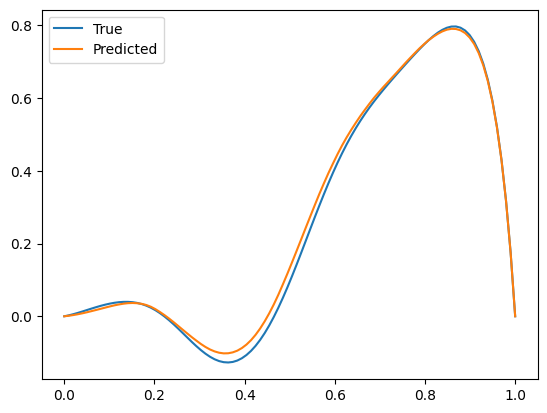

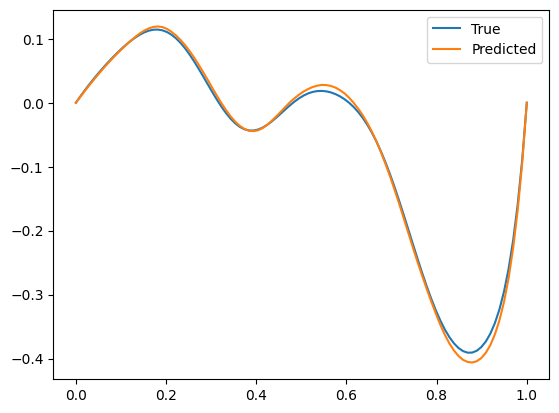

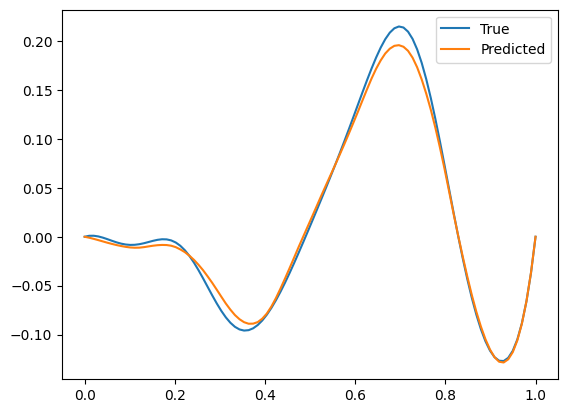

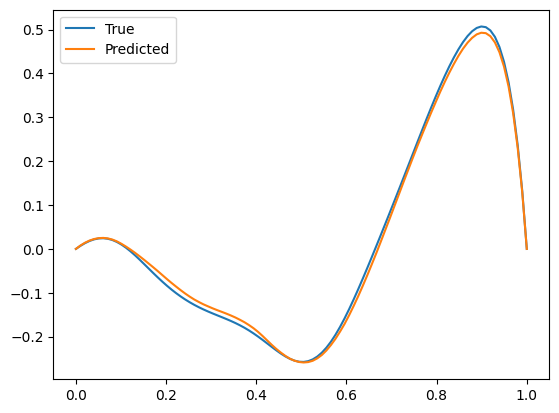

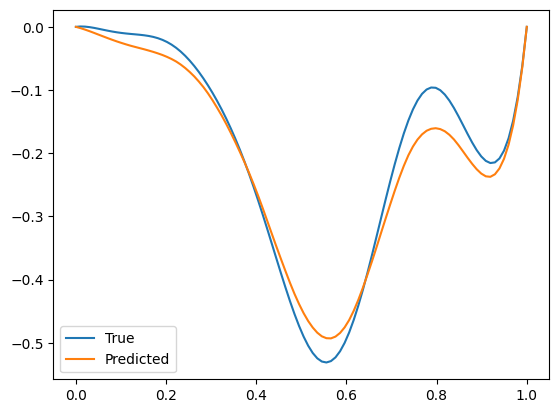

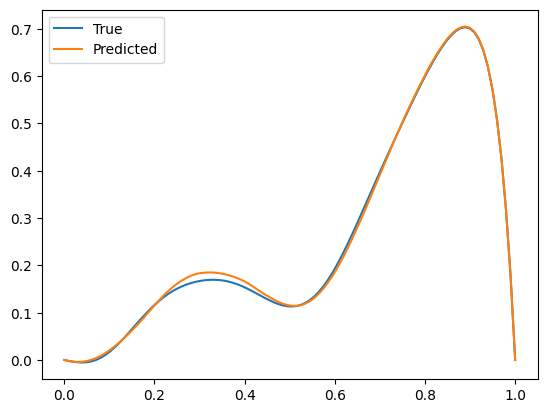

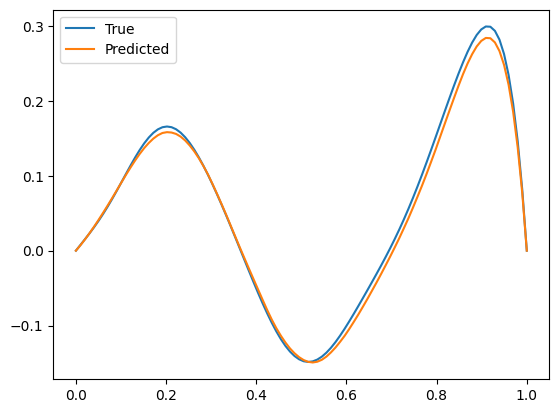

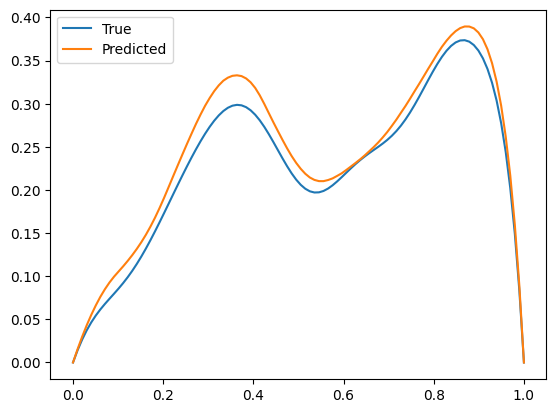

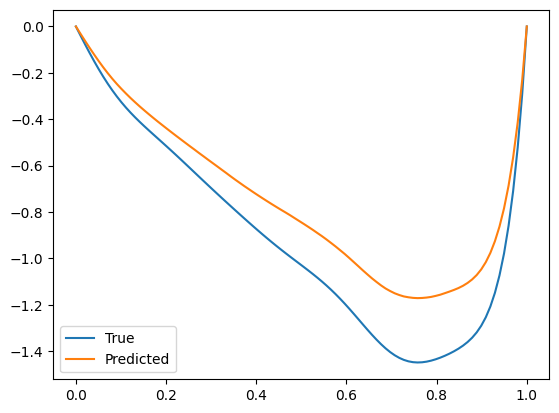

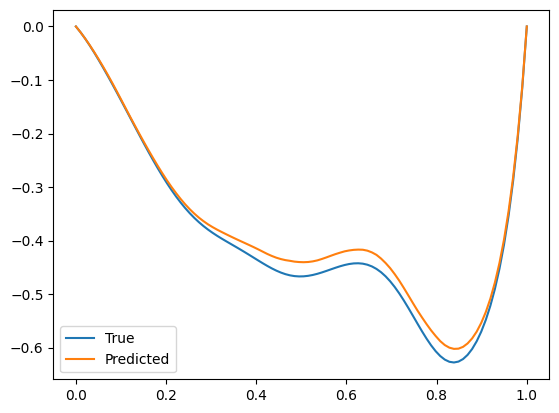

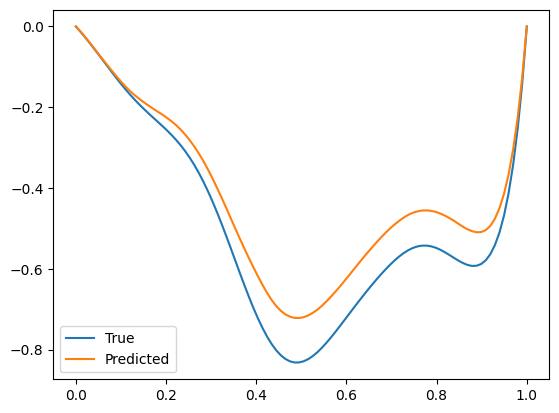

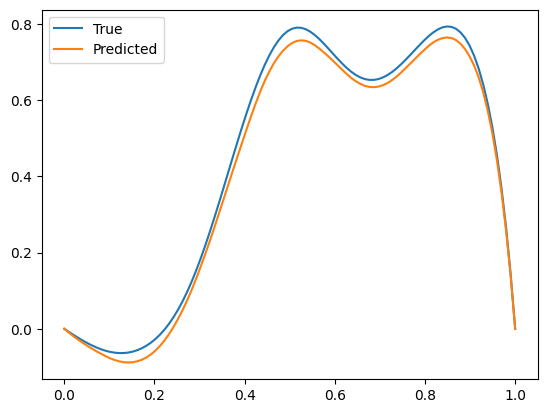

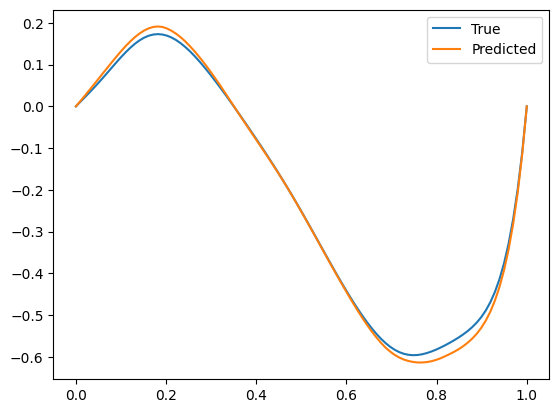

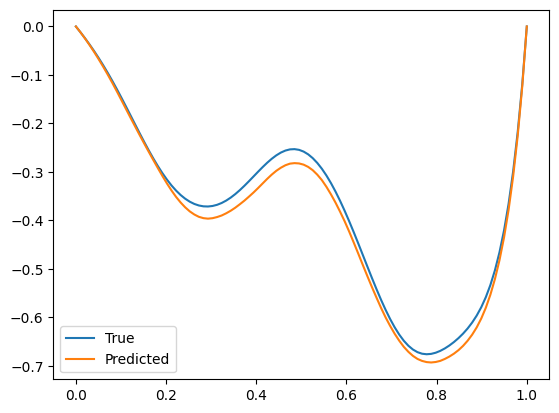

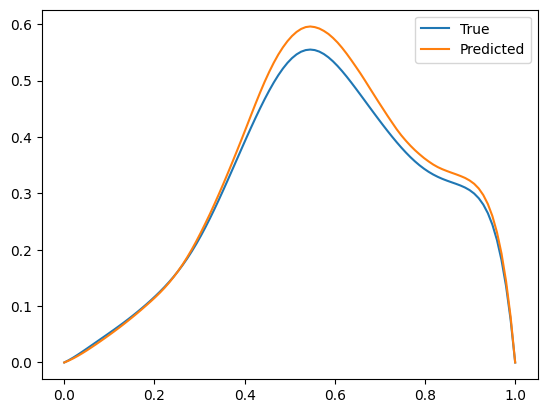

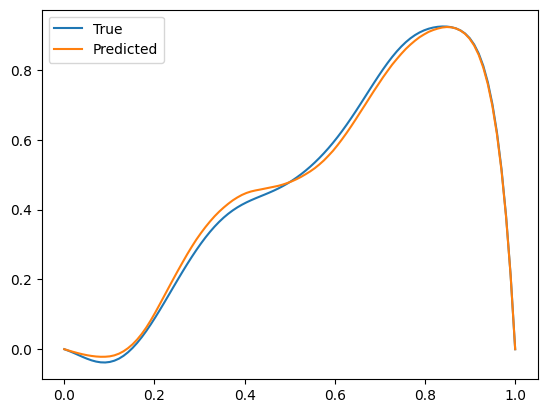

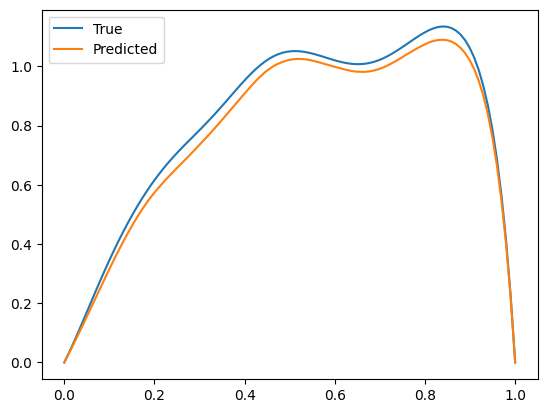

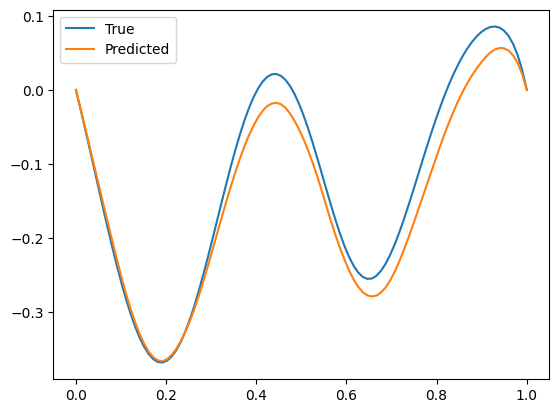

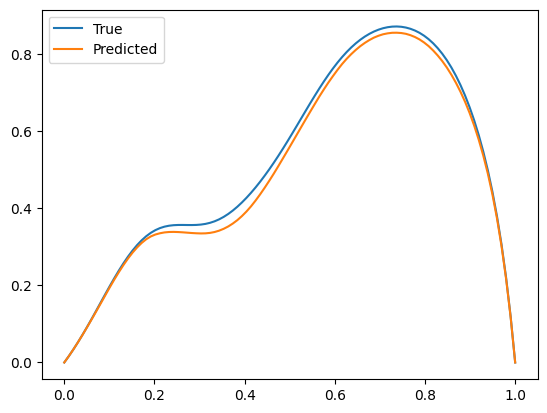

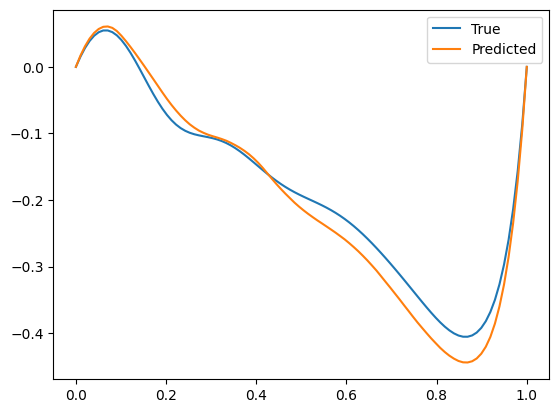

In [13]:
# then we can test the model
mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

preds = model.predict(mu_test, xs_test)
for i in range(20):
    plt.plot(xs_test[i,:],sol_test[i,:], label='True')
    plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
    plt.legend()
    plt.show()